                AAPL    ABNB    ADBE       ADI       ADP    ADSK       AEP  \
Date                                                                         
2023-01-03  123.6325   84.90  336.92  156.0760  226.1810  185.15  86.77769   
2023-01-04  124.9077   88.72  341.41  159.4002  227.2469  187.96  87.37224   
2023-01-05  123.5831   87.71  328.44  153.4243  222.3457  182.07  85.78066   
2023-01-06  128.1302   88.52  332.75  159.0255  228.5603  187.19  88.29609   
2023-01-09  128.6541   89.24  341.98  160.5435  227.9417  192.47  89.59496   
...              ...     ...     ...       ...       ...     ...       ...   
2023-12-22  192.4446  140.80  598.75  192.9726  224.8101  242.76  76.51824   
2023-12-26  191.8979  138.72  598.26  194.7056  226.3382  245.07  76.85143   
2023-12-27  191.9973  136.55  596.08  195.1755  225.4330  245.11  76.92758   
2023-12-28  192.4247  137.00  595.52  196.0469  226.2896  244.91  77.42261   
2023-12-29  191.3810  136.14  596.60  194.4021  226.7568  243.48

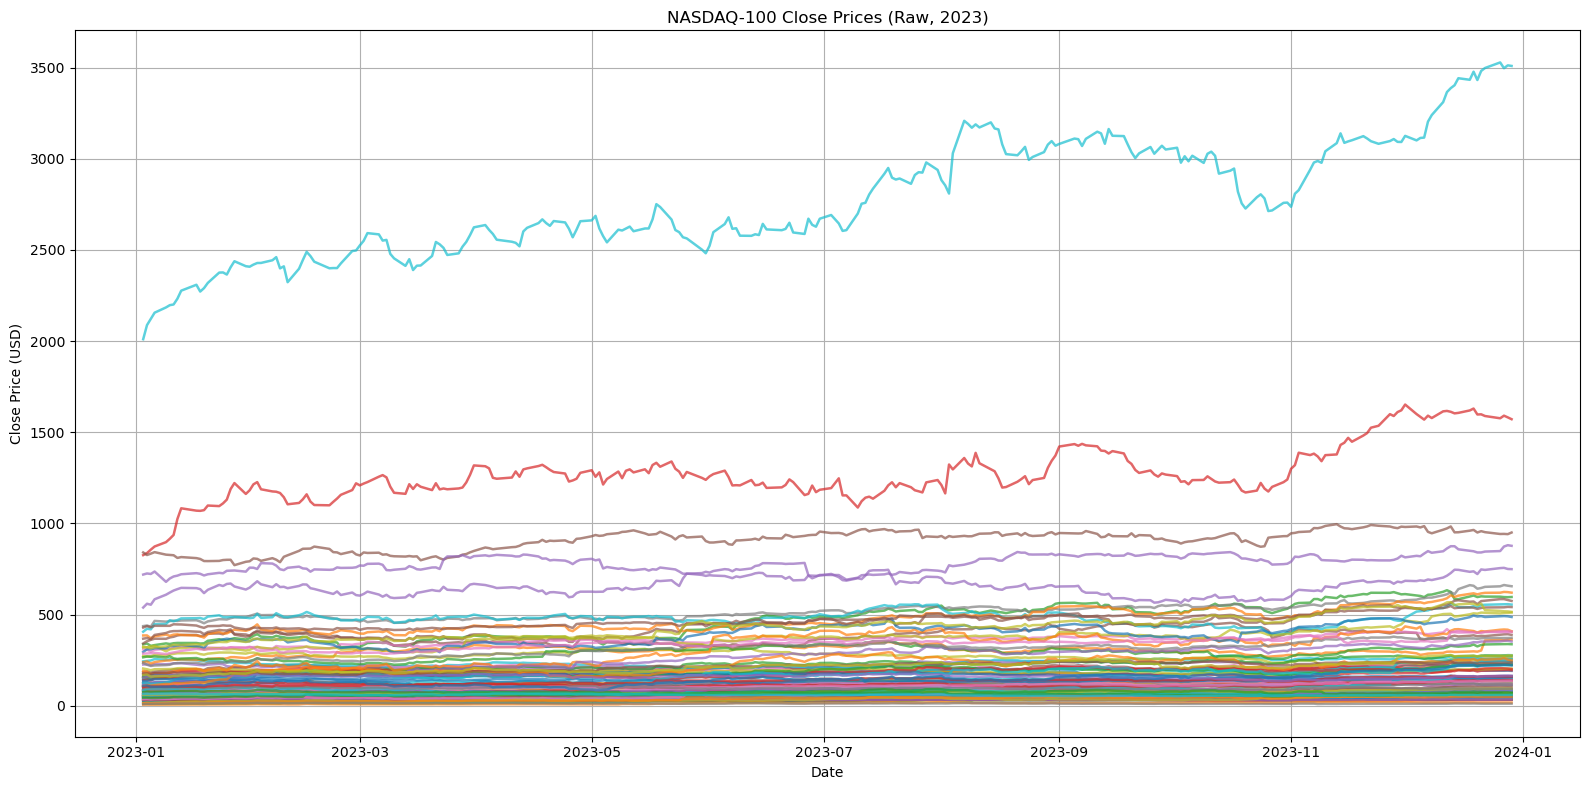

Stocks with prices above $500 in 2023 are :
['ADBE', 'ASML', 'BKNG', 'COST', 'IDXX', 'INTU', 'KLAC', 'LULU', 'MELI', 'ORLY', 'REGN', 'ROP', 'SNPS']


In [1]:
                                            # CELL 1 
#Import Nasdaq100 dataset to create a single CSV with Yr2023 and AdjClose prices

import os
import pandas as pd
import matplotlib.pyplot as plt

# Set your CSV folder path
data_dir = "Z:\\U of Leicester\\Project Work\\Nasdaq100"  # <- change this to your actual path

# Empty list to hold individual ticker dataframes
df_list = []

# Loop through each CSV file
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        filepath = os.path.join(data_dir, filename)
        ticker = filename.replace(".csv", "")

        # Load CSV and parse custom date format  
        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    

        # Filter only 2023 data
        df = df[(df['Date'] >= '2023-01-01') & (df['Date'] <= '2023-12-31')]

        # Keep Date + Adj Close, and rename Adj Close to ticker
        df = df[['Date', 'Close']].rename(columns={'Close': ticker})

        df_list.append(df)

# Merge all dataframes on 'Date'
combined_df = df_list[0]
for df in df_list[1:]:
    combined_df = pd.merge(combined_df, df, on='Date', how='outer')

# Sort by date and set Date as index
combined_df = combined_df.sort_values('Date').set_index('Date')

# Save result to CSV
combined_df.to_csv("nasdaq100_timeseries_2023_v1.csv")

# Display first few rows
print(combined_df)

# 1. Plot All Tickers (Raw Prices) — Overlaid Line Chart
# Plot from combined_df, not df
plt.figure(figsize=(16, 8))

for ticker in combined_df.columns:
    plt.plot(combined_df.index, combined_df[ticker], alpha=0.7, linewidth=1.8)

plt.title("NASDAQ-100 Close Prices (Raw, 2023)")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

######

# Find stocks that have prices above $500 at any point in 2023
high_value_stocks = []
for ticker in combined_df.columns:
    if (combined_df[ticker] > 500).any():
        high_value_stocks.append(ticker)

print("Stocks with prices above $500 in 2023 are :")
print(high_value_stocks)

#####

In [2]:
                                                        # CELL 2
#### NORMALIZATIONS #####  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Load the data
data = pd.read_csv('nasdaq100_timeseries_2023_v1.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# 1. Min-Max Scaling (Raw Prices)
def min_max_normalization(df):
    scaler = MinMaxScaler()
    normalized = pd.DataFrame(
        scaler.fit_transform(df),
        index=df.index,
        columns=df.columns
    )
    return normalized

# 2. Z-score Standardization (Raw Prices)
def z_score_normalization(df):
    scaler = StandardScaler()
    normalized = pd.DataFrame(
        scaler.fit_transform(df),
        index=df.index,
        columns=df.columns
    )
    return normalized

# 3. Percentage Returns
def percentage_returns(df):
    returns = df.pct_change().dropna()
    return returns

# 4. Log Returns
def log_returns(df):
    log_ret = np.log(df / df.shift(1)).dropna()
    return log_ret

# 5. Robust Scaling (using median and IQR)
def robust_scaling(df):
    scaler = RobustScaler()
    normalized = pd.DataFrame(
        scaler.fit_transform(df),
        index=df.index,
        columns=df.columns
    )
    return normalized

# Apply all normalization methods
normalized_data = {
    'min_max': min_max_normalization(data),
    'z_score': z_score_normalization(data),
    'percentage_returns': percentage_returns(data),
    'log_returns': log_returns(data),
    'robust_scaling': robust_scaling(data)
}

# Calculate summary statistics for each method
def calculate_stats(normalized_dict):
    stats = {}
    for method_name, df in normalized_dict.items():
        # Basic statistics
        stats[method_name] = {
            'mean': df.values.mean(),
            'std': df.values.std(),
            'min': df.values.min(),
            'max': df.values.max(),
            'median': np.median(df.values)
        }
        
        # Skewness and kurtosis (distributional properties)
        stats[method_name]['skewness'] = df.skew().mean()
        stats[method_name]['kurtosis'] = df.kurtosis().mean()
        
        # Stationarity check using ADF test (sample 5 stocks)
        sample_stocks = df.columns[:5]
        adf_pvalues = []
        
        for stock in sample_stocks:
            try:
                result = adfuller(df[stock].dropna())    ##ADF test for stationary or non-stationary time series
                adf_pvalues.append(result[1])  # p-value
            except:
                continue
                
        if adf_pvalues:
            stats[method_name]['avg_adf_pvalue'] = np.mean(adf_pvalues)
        else:
            stats[method_name]['avg_adf_pvalue'] = np.nan
            
    return pd.DataFrame(stats).T

# Get statistics
normalization_stats = calculate_stats(normalized_data)
print(normalization_stats)

# Visualize sample stocks for each normalization method
def plot_normalizations(normalized_dict, n_stocks=5):
    sample_stocks = data.columns[:n_stocks]
    
    for method_name, df in normalized_dict.items():
        plt.figure(figsize=(12, 6))
        for stock in sample_stocks:
            plt.plot(df[stock], label=stock)
        
        plt.title(f'Normalized using {method_name}')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'normalized_{method_name}.png')
        plt.close()

# Generate plots
plot_normalizations(normalized_data)

# Create correlation heatmaps 
def plot_correlation_heatmaps(normalized_dict):
    for method_name, df in normalized_dict.items():
        # Take a subset of stocks for clearer visualization
        sample_df = df.iloc[:, :20]  # First 20 stocks
        
        plt.figure(figsize=(12, 10))
        correlation = sample_df.corr()
        sns.heatmap(correlation, annot=False, cmap='coolwarm')
        
        plt.title(f'Correlation Matrix - {method_name}')
        plt.tight_layout()
        plt.savefig(f'correlation_{method_name}.png')
        plt.close()

# Generate correlation heatmaps
plot_correlation_heatmaps(normalized_data)
 
# Recommendations
print("\nRecommendations based on statistical properties:")
# Sort by stationarity (lower ADF p-value is better)
stationarity_ranking = normalization_stats.sort_values('avg_adf_pvalue')
print("Ranking by stationarity (lower p-value is better):")
print(stationarity_ranking[['avg_adf_pvalue']])

# FIXED PART: Sort by normality (closer to zero skewness and kurtosis is better)
# Calculate a new column for normality score (absolute sum of skewness and kurtosis)
normalization_stats['normality_score'] = abs(normalization_stats['skewness']) + abs(normalization_stats['kurtosis'])
# Now sort by this column
normality_ranking = normalization_stats.sort_values(by='normality_score')
print("\nRanking by normality (closer to normal distribution):")
print(normality_ranking[['skewness', 'kurtosis', 'normality_score']])

print("\nFor financial time series clustering, the recommended methods are:")
print("1. Percentage Returns - for financial interpretability and good stationarity")
print("2. Log Returns - for financial interpretability and handling of outliers")
print("3. Z-score Standardization - if comparing stocks with different scales is important")



                        mean       std       min       max    median  \
min_max                  NaN       NaN       NaN       NaN       NaN   
z_score                  NaN       NaN       NaN       NaN       NaN   
percentage_returns  0.001444  0.019928 -0.217672  0.284727  0.001487   
log_returns         0.001246  0.019848 -0.245482  0.250546  0.001485   
robust_scaling           NaN       NaN       NaN       NaN       NaN   

                    skewness  kurtosis  avg_adf_pvalue  
min_max             0.090574 -0.534742        0.299213  
z_score             0.090574 -0.534742        0.299213  
percentage_returns  0.053138  4.669637        0.000478  
log_returns        -0.081493  4.615295        0.000457  
robust_scaling      0.090574 -0.534742        0.299213  

Recommendations based on statistical properties:
Ranking by stationarity (lower p-value is better):
                    avg_adf_pvalue
log_returns               0.000457
percentage_returns        0.000478
robust_scaling     


1. Data Quality Check:
Number of NaN values: 0
Number of infinite values: 0

2. Distribution Properties (Overall):
Mean: 0.001246
Median: 0.001485
Std Dev: 0.019848
Skewness: 0.071823
Kurtosis: 15.119918

3. Stationarity Tests (ADF):
     ADF Statistic   p-value Stationary
AAPL     -3.868815  0.002277       True
ABNB     -8.940477       0.0       True
ADBE     -8.514639       0.0       True
ADI      -5.196343  0.000009       True
ADP       -9.05838       0.0       True
ADSK     -5.250367  0.000007       True
AEP      -9.847059       0.0       True
AMAT    -10.391208       0.0       True
AMD      -4.766972  0.000063       True
AMGN     -4.902422  0.000034       True
Percentage of stationary stocks: 10.00%


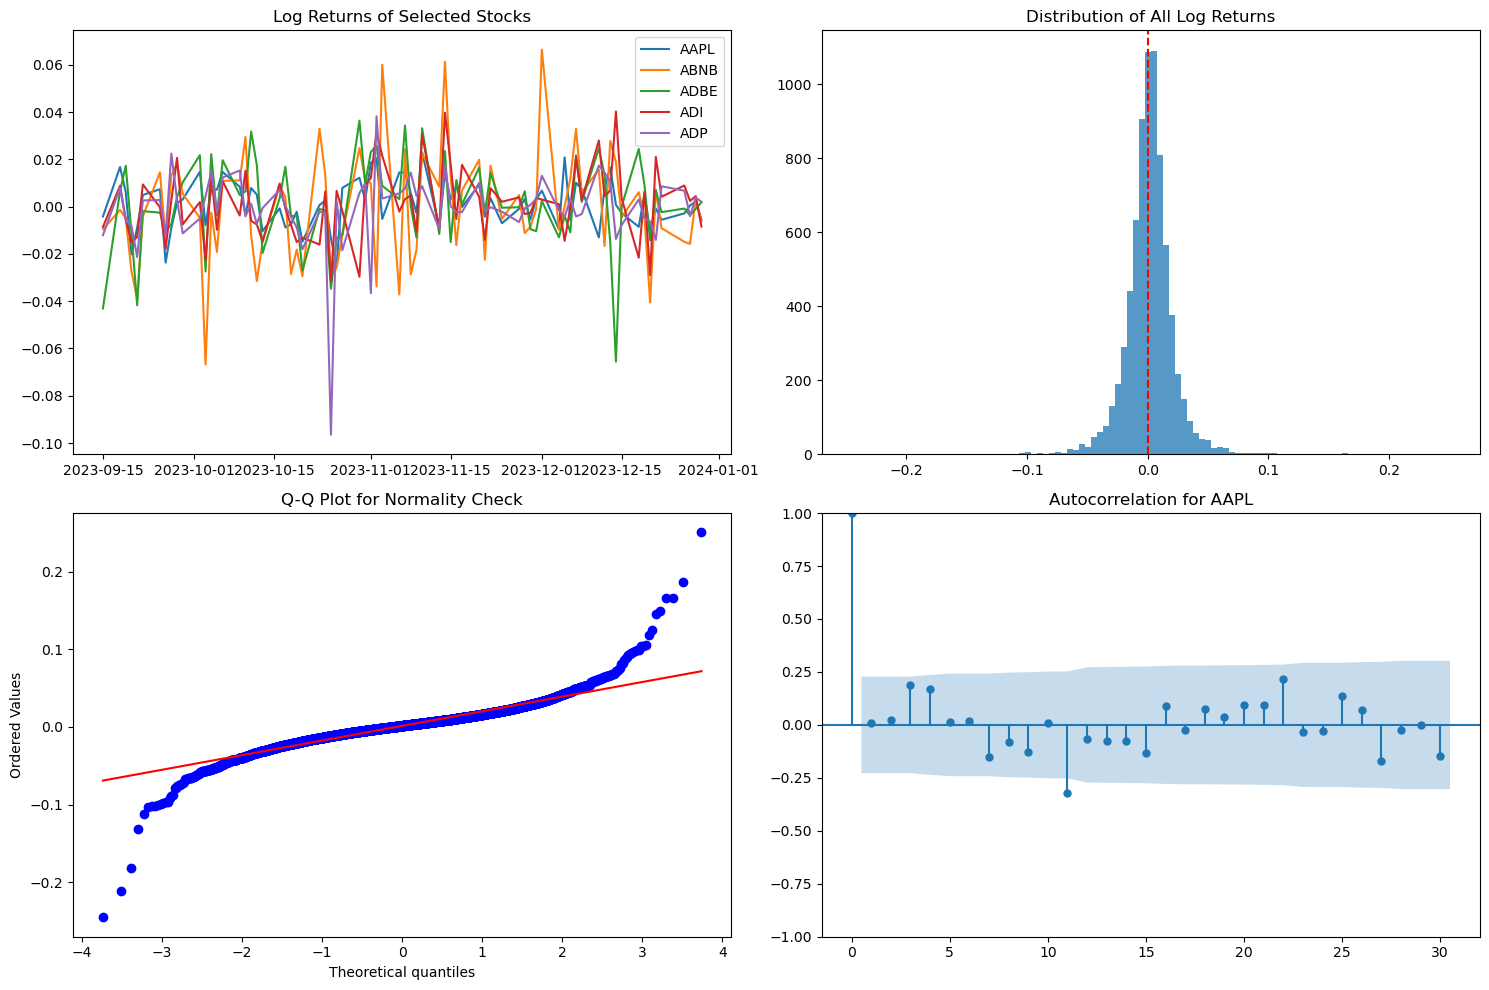

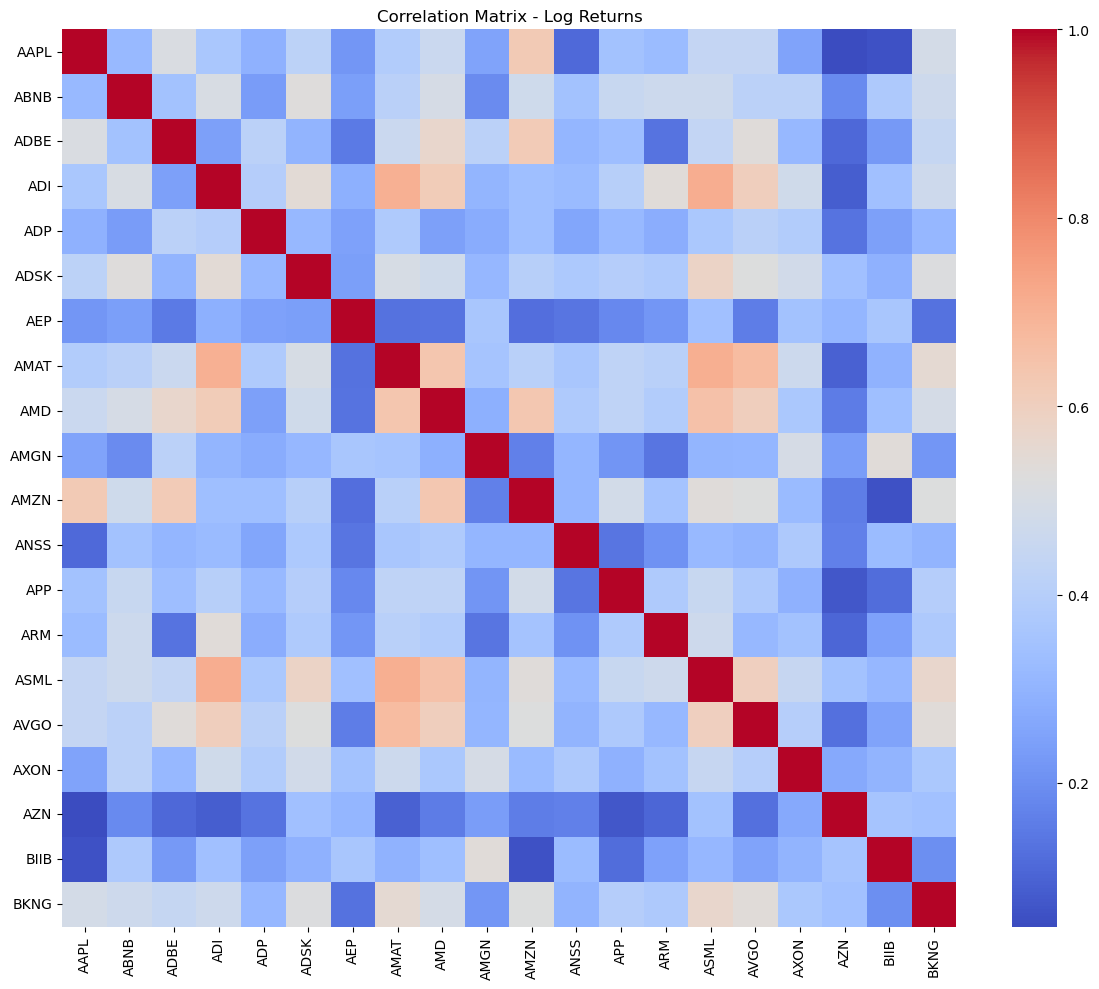


--- VALIDATION SUMMARY ---
Stationarity validation: PASSED
Distribution validation: FAILED
Data quality validation: PASSED

Log returns normalization completed with some concerns. Review the validation metrics above.


In [3]:
                                                        #CELL 3
## Implementing and Validating the Log Normalization 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Function to calculate log returns
def calculate_log_returns(df):
    """
    Calculate log returns from price data.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with stock prices (columns are stocks, index is dates)
    
    Returns:
    pandas.DataFrame: DataFrame with log returns
    """
    log_ret = np.log(df / df.shift(1)).dropna()
    return log_ret

# Load the data
# Assuming your data is in a CSV file with 'Date' column and stock symbols as other columns
data = pd.read_csv('nasdaq100_timeseries_2023_v1.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Calculate log returns
log_returns = calculate_log_returns(data)

# Save normalized data
log_returns.to_csv('nasdaq100_log_returns.csv')

# --- VALIDATION METRICS ---

# 1. Check for NaN or Infinite values
print("\n1. Data Quality Check:")
print(f"Number of NaN values: {log_returns.isna().sum().sum()}")
print(f"Number of infinite values: {np.isinf(log_returns).sum().sum()}")

# 2. Distribution properties (first check overall, then by stock)
print("\n2. Distribution Properties (Overall):")
all_returns = log_returns.values.flatten()
print(f"Mean: {np.mean(all_returns):.6f}")
print(f"Median: {np.median(all_returns):.6f}")
print(f"Std Dev: {np.std(all_returns):.6f}")
print(f"Skewness: {pd.Series(all_returns).skew():.6f}")
print(f"Kurtosis: {pd.Series(all_returns).kurtosis():.6f}")

# 3. Stationarity Test (ADF)
print("\n3. Stationarity Tests (ADF):")
# Test a sample of stocks
sample_stocks = log_returns.columns[:10]  # First 10 stocks
adf_results = {}

for stock in sample_stocks:
    result = adfuller(log_returns[stock].dropna())
    adf_results[stock] = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Stationary': result[1] < 0.05
    }

adf_df = pd.DataFrame(adf_results).T
print(adf_df)
print(f"Percentage of stationary stocks: {(adf_df['Stationary'].sum() / len(adf_df) * 100):.2f}%")

# 4. Visual confirmation
plt.figure(figsize=(15, 10))

# a. Sample log returns plot
plt.subplot(2, 2, 1)
for stock in sample_stocks[:5]:  # First 5 stocks
    plt.plot(log_returns[stock], label=stock)
plt.title('Log Returns of Selected Stocks')
plt.legend()

# b. Histogram of all returns
plt.subplot(2, 2, 2)
plt.hist(all_returns, bins=100, alpha=0.75)
plt.title('Distribution of All Log Returns')
plt.axvline(x=0, color='r', linestyle='--')

# c. QQ plot to check normality
plt.subplot(2, 2, 3)
from scipy import stats
stats.probplot(all_returns[~np.isnan(all_returns)], plot=plt)
plt.title('Q-Q Plot for Normality Check')

# d. Autocorrelation plot for a sample stock
plt.subplot(2, 2, 4)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(log_returns[sample_stocks[0]].dropna(), lags=30, ax=plt.gca())
plt.title(f'Autocorrelation for {sample_stocks[0]}')

plt.tight_layout()
plt.savefig('log_returns_validation.png')
plt.show()

# 5. Correlation heatmap
plt.figure(figsize=(12, 10))
sample_df = log_returns.iloc[:, :20]  # First 20 stocks for better visualization
correlation = sample_df.corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix - Log Returns')
plt.tight_layout()
plt.savefig('log_returns_correlation.png')
plt.show()

# 6. Summary assessment
print("\n--- VALIDATION SUMMARY ---")
average_pvalue = adf_df['p-value'].mean()
all_skewness = abs(pd.Series(all_returns).skew())
excess_kurtosis = abs(pd.Series(all_returns).kurtosis())

# Decision criteria
stationarity_ok = average_pvalue < 0.05
distribution_ok = all_skewness < 1.0 and excess_kurtosis < 5.0
data_quality_ok = (log_returns.isna().sum().sum() == 0) and (np.isinf(log_returns).sum().sum() == 0)

print(f"Stationarity validation: {'PASSED' if stationarity_ok else 'FAILED'}")
print(f"Distribution validation: {'PASSED' if distribution_ok else 'FAILED'}")
print(f"Data quality validation: {'PASSED' if data_quality_ok else 'FAILED'}")

if stationarity_ok and distribution_ok and data_quality_ok:
    print("\nLog returns normalization completed successfully and passed all validation checks!")
else:
    print("\nLog returns normalization completed with some concerns. Review the validation metrics above.")

Loading log returns data...
Loaded data with 101 stocks and 74 time periods.
Calculating volatility features...
Processing stock 1/101: AAPL
Processing stock 11/101: AMZN
Processing stock 21/101: BKR
Processing stock 31/101: CSCO
Processing stock 41/101: FANG
Processing stock 51/101: INTC
Processing stock 61/101: MCHP
Processing stock 71/101: NFLX
Processing stock 81/101: PEP
Processing stock 91/101: TMUS
Processing stock 101/101: ZS
Generated 1212 volatility features.
Saved volatility features to nasdaq100_volatility_features.csv

Extracting specific volatility metrics for analysis...

Volatility Summary Statistics:

Top 10 stocks by average volatility:
     symbol      mean       std       max
MSTR   MSTR  0.037476  0.002670  0.043122
PDD     PDD  0.035627  0.009738  0.040642
MDB     MDB  0.034732  0.000396  0.035244
ARM     ARM  0.034670  0.001544  0.037571
PLTR   PLTR  0.034630  0.003193  0.040386
WBD     WBD  0.034221  0.002235  0.036852
AMD     AMD  0.026960  0.000570  0.027665
M

C:\Users\Dennis\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dennis\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Cluster 1 - Volatility level: MEDIUM
  Average volatility: 0.0185 (1.85%)
  Stocks: MCHP, GOOGL, GOOG, SNPS, KLAC, ADBE, DXCM, LRCX, GEHC, NVDA and 7 more

Cluster 2 - Volatility level: HIGH
  Average volatility: 0.0352 (3.52%)
  Stocks: WBD, PLTR, ARM, MDB, PDD, MSTR

Cluster 3 - Volatility level: LOW
  Average volatility: 0.0099 (0.99%)
  Stocks: TMUS, EA, ADP, CDW, ROP, PCAR, FAST, HON, KHC, AAPL and 17 more

Cluster 4 - Volatility level: HIGH
  Average volatility: 0.0236 (2.36%)
  Stocks: INTC, ODFL, CRWD, TSLA, ANSS, ABNB, GFS, EXC, PANW, TEAM and 9 more

Cluster 5 - Volatility level: MEDIUM
  Average volatility: 0.0138 (1.38%)
  Stocks: GILD, CSX, AMZN, FANG, XEL, ORLY, AEP, CMCSA, TTWO, ASML and 22 more

2. Correlation Patterns:
  • Average correlation between stock volatilities: 0.0737
  • LOW market-wide correlation: Stocks have mostly independent volatility patterns

  • Stocks most correlated with others (volatility influencers):
    - CTSH: 0.2526
    - ASML: 0.2220
    - 

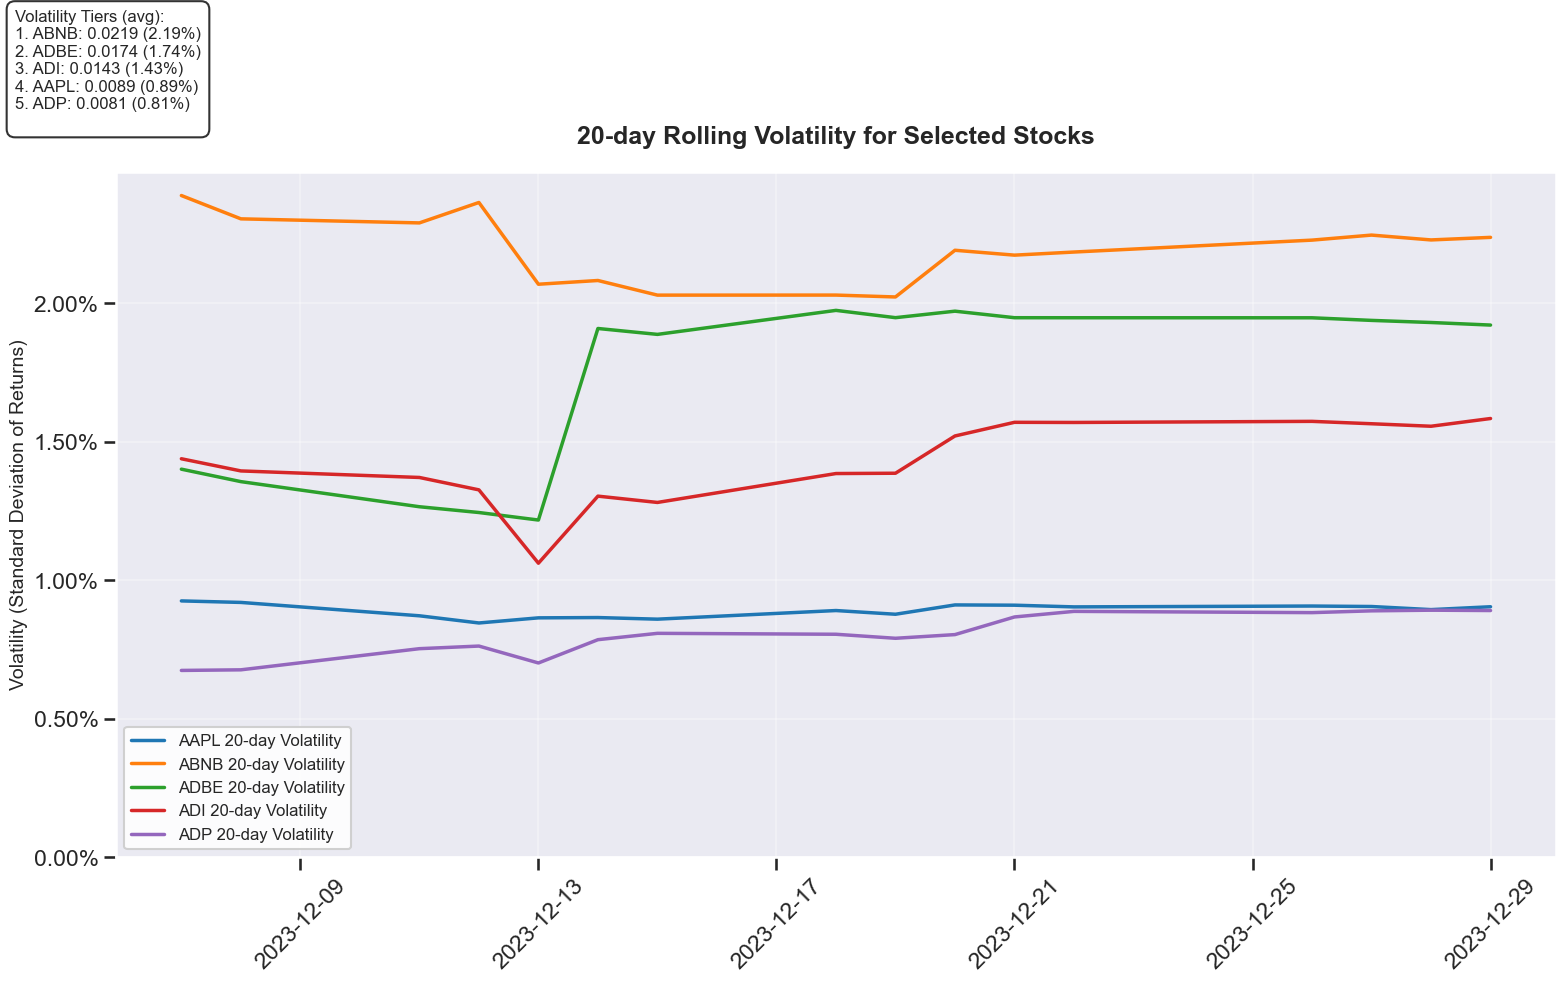

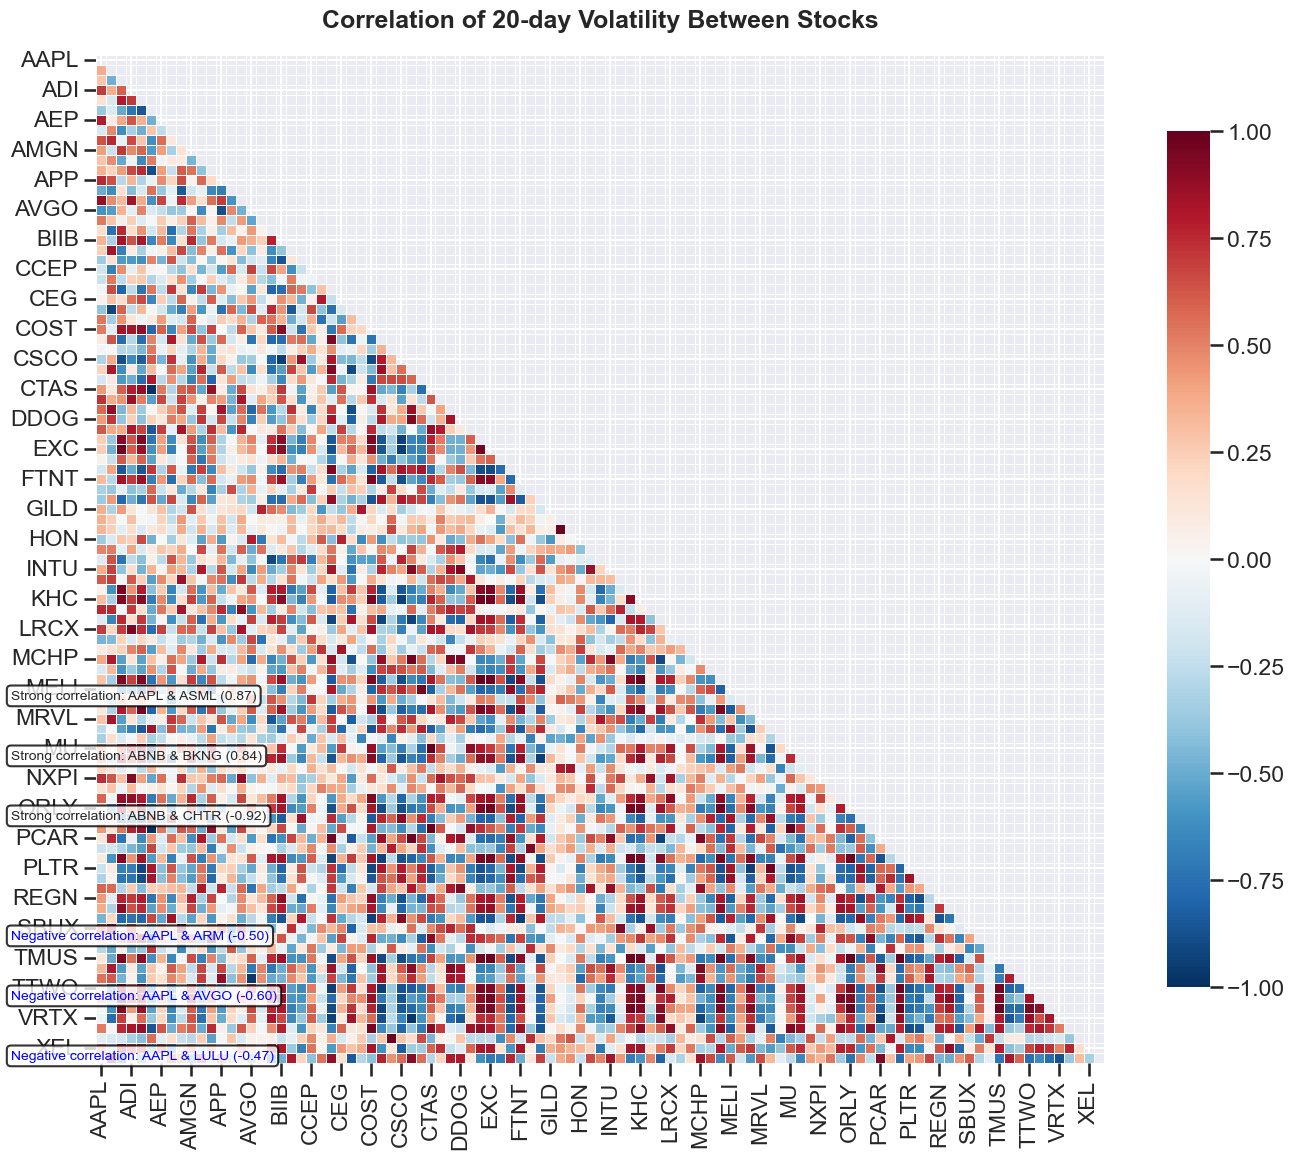

In [4]:
                                                        #CELL 4
##Step by step plan: Point 2.1 Volatality and its features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap
import os
os.environ['OMP_NUM_THREADS'] = '1'

# Set the style for all plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("talk")

# Custom color palette for better visualization
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_diverging',
    ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'],
    N=256
)

# Load the log returns data 
print("Loading log returns data...")
try:
    log_returns = pd.read_csv('nasdaq100_log_returns.csv', index_col='Date', parse_dates=True)
    print(f"Loaded data with {log_returns.shape[1]} stocks and {log_returns.shape[0]} time periods.")
except FileNotFoundError:
    print("Log returns file not found. Please make sure 'nasdaq100_log_returns.csv' exists.")
    # Create sample data for demonstration if file not found
    log_returns = pd.DataFrame(
        np.random.normal(0, 0.01, size=(100, 5)),
        columns=['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP'],
        index=pd.date_range(start='2023-01-01', periods=100, freq='B')
    )
    print("Created sample data for demonstration.")

# Function to calculate volatility features
def calculate_volatility_features(returns_df, windows=[5, 10, 20, 30]):
    """
    Calculate volatility-based features for each stock in the returns dataframe.
    
    Parameters:
    returns_df (pandas.DataFrame): DataFrame containing log returns
    windows (list): List of window sizes for rolling calculations
    
    Returns:
    pandas.DataFrame: DataFrame with volatility features for each stock
    """
    print("Calculating volatility features...")
    
    # Initialize an empty DataFrame to store features
    all_features = pd.DataFrame()
    
    # Loop through each stock
    for i, stock in enumerate(returns_df.columns):
        if i % 10 == 0:  # Progress indicator
            print(f"Processing stock {i+1}/{len(returns_df.columns)}: {stock}")
            
        stock_returns = returns_df[stock]
        features = pd.DataFrame(index=stock_returns.index)
        
        # Calculate rolling volatility for different windows
        for window in windows:
            # Rolling standard deviation (volatility)
            rolling_vol = stock_returns.rolling(window=window).std()
            features[f'{stock}_vol_{window}d'] = rolling_vol
            
            # Rolling volatility of volatility (volatility clustering)
            vol_of_vol = rolling_vol.rolling(window=window).std()
            features[f'{stock}_vol_of_vol_{window}d'] = vol_of_vol
            
            # Maximum drawdown within window
            rolling_drawdown = stock_returns.rolling(window=window).apply(
                lambda x: (1 + x).cumprod().min() - 1, raw=True
            )
            features[f'{stock}_drawdown_{window}d'] = rolling_drawdown
        
        # If this is the first stock, use its index for all_features
        if all_features.empty:
            all_features = features
        else:
            # Otherwise, join with existing features
            all_features = all_features.join(features)
    
    # Drop NaN values (from rolling windows)
    all_features = all_features.dropna()
    print(f"Generated {all_features.shape[1]} volatility features.")
    
    return all_features

# Calculate volatility features
volatility_features = calculate_volatility_features(log_returns)

# Save the features to a CSV file
output_file = 'nasdaq100_volatility_features.csv'
volatility_features.to_csv(output_file)
print(f"Saved volatility features to {output_file}")

# Extract specific volatility metrics for visualization and analysis
print("\nExtracting specific volatility metrics for analysis...")

# Get all 20-day volatility columns for all stocks
vol_20d_columns = [col for col in volatility_features.columns if 'vol_20d' in col and 'vol_of_vol' not in col]
vol_20d_df = volatility_features[vol_20d_columns].copy()

# Rename columns to just stock symbols for cleaner visualization
vol_20d_df.columns = [col.split('_vol_')[0] for col in vol_20d_df.columns]

# If there are more than 5 stocks, select the first 5 for visualization
selected_stocks = vol_20d_df.columns[:5] if len(vol_20d_df.columns) > 5 else vol_20d_df.columns
vol_selected = vol_20d_df[selected_stocks]

# Summarize the volatility features
print("\nVolatility Summary Statistics:")
vol_stats = vol_20d_df.describe().T
vol_stats['symbol'] = vol_stats.index
vol_stats = vol_stats.sort_values('mean', ascending=False)
print("\nTop 10 stocks by average volatility:")
print(vol_stats[['symbol', 'mean', 'std', 'max']].head(10))

# Create a function for generating detailed CSV explanation
def explain_csv_columns(df):
    """Generate a detailed explanation of the CSV columns."""
    print("\n----- DETAILED CSV COLUMN EXPLANATION -----")
    
    # Get the first stock for example
    first_stock = df.columns[0].split('_vol_')[0] if '_vol_' in df.columns[0] else df.columns[0]
    
    # Explain each feature type
    print(f"\nFor stock {first_stock}, the features include:")
    
    # Volatility metrics
    for window in [5, 10, 20, 30]:
        vol_col = f"{first_stock}_vol_{window}d"
        if vol_col in df.columns:
            print(f"\n{vol_col}:")
            print(f"  • {window}-day rolling volatility (standard deviation of returns)")
            print(f"  • Measures price fluctuations over the past {window} trading days")
            print(f"  • Higher values indicate greater risk/uncertainty")
            
            # Example value
            example_value = df[vol_col].dropna().iloc[-1] if not df[vol_col].dropna().empty else "N/A"
            print(f"  • Recent value: {example_value:.6f} ({example_value*100:.2f}%)")
    
    # Volatility of volatility metrics
    for window in [5, 10, 20, 30]:
        vol_of_vol_col = f"{first_stock}_vol_of_vol_{window}d"
        if vol_of_vol_col in df.columns:
            print(f"\n{vol_of_vol_col}:")
            print(f"  • Volatility of the {window}-day volatility")
            print(f"  • Measures how stable or predictable the volatility itself is")
            print(f"  • Higher values indicate volatility is changing rapidly (volatility clustering)")
            
            # Example value
            example_value = df[vol_of_vol_col].dropna().iloc[-1] if not df[vol_of_vol_col].dropna().empty else "N/A"
            print(f"  • Recent value: {example_value:.6f}")
    
    # Drawdown metrics
    for window in [5, 10, 20, 30]:
        drawdown_col = f"{first_stock}_drawdown_{window}d"
        if drawdown_col in df.columns:
            print(f"\n{drawdown_col}:")
            print(f"  • Maximum drawdown within the past {window} trading days")
            print(f"  • Measures downside risk/worst-case scenario")
            print(f"  • More negative values indicate larger price drops")
            
            # Example value
            example_value = df[drawdown_col].dropna().iloc[-1] if not df[drawdown_col].dropna().empty else "N/A"
            print(f"  • Recent value: {example_value:.6f} ({example_value*100:.2f}%)")
    
    # Compare two stocks
    if len(df.columns) >= 2:
        first_stock = df.columns[0].split('_vol_')[0] if '_vol_' in df.columns[0] else df.columns[0]
        second_stock = df.columns[1].split('_vol_')[0] if '_vol_' in df.columns[1] else df.columns[1]
        
        # Get 20-day volatility for comparison if available
        first_col = [col for col in df.columns if first_stock in col and 'vol_20d' in col and 'vol_of_vol' not in col]
        second_col = [col for col in df.columns if second_stock in col and 'vol_20d' in col and 'vol_of_vol' not in col]
        
        if first_col and second_col:
            first_vol = df[first_col[0]].mean()
            second_vol = df[second_col[0]].mean()
            
            print(f"\n----- COMPARISON: {first_stock} vs {second_stock} -----")
            print(f"Average 20-day volatility:")
            print(f"  • {first_stock}: {first_vol:.6f} ({first_vol*100:.2f}%)")
            print(f"  • {second_stock}: {second_vol:.6f} ({second_vol*100:.2f}%)")
            
            if first_vol > second_vol:
                ratio = first_vol / second_vol
                print(f"  • {first_stock} is {ratio:.2f}x more volatile than {second_stock}")
            else:
                ratio = second_vol / first_vol
                print(f"  • {second_stock} is {ratio:.2f}x more volatile than {first_stock}")
            
            # Correlation analysis
            corr = vol_20d_df[[first_stock, second_stock]].corr().iloc[0,1]
            print(f"\nVolatility correlation: {corr:.4f}")
            
            if corr > 0.7:
                print(f"  • Strong positive correlation - these stocks tend to be volatile at the same time")
            elif corr > 0.3:
                print(f"  • Moderate positive correlation - some similarity in volatility patterns")
            elif corr > -0.3:
                print(f"  • Weak correlation - volatility patterns are mostly independent")
            elif corr > -0.7:
                print(f"  • Moderate negative correlation - tend to have opposite volatility patterns")
            else:
                print(f"  • Strong negative correlation - when one is volatile, the other tends to be stable")
    
    print("\n----- END OF CSV EXPLANATION -----")

# Generate detailed CSV explanation
explain_csv_columns(volatility_features)

# Create enhanced visualization of volatility
print("\nCreating enhanced volatility visualization...")

plt.figure(figsize=(16, 9))
ax = plt.gca()

# Plot each stock with a distinct color and line style
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Blue, Orange, Green, Red, Purple
for i, stock in enumerate(selected_stocks):
    plt.plot(vol_selected.index, vol_selected[stock], 
             label=f'{stock} 20-day Volatility',
             color=colors[i % len(colors)], 
             linewidth=2.5)

# Customize the plot
plt.title('20-day Rolling Volatility for Selected Stocks', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Volatility (Standard Deviation of Returns)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, frameon=True, facecolor='white', framealpha=0.9)

# Format x-axis for better date readability
date_form = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Adjust y-axis to start from 0
plt.ylim(bottom=0)

# Identify significant volatility events
if len(vol_selected) > 0:
    # Find the date with the biggest volatility drop
    vol_diff = vol_selected.diff()
    biggest_drop_date = vol_diff.min().idxmin()
    biggest_drop_stock = vol_diff.min().idxmin()
    
    # Find the date with the biggest volatility spike
    biggest_spike_date = vol_diff.max().idxmax()
    biggest_spike_stock = vol_diff.max().idxmax()
    
    # Find the most volatile period (highest volatility)
    most_volatile_date = vol_selected.max().idxmax()
    most_volatile_stock = vol_selected.max().idxmax()
    most_volatile_value = vol_selected.loc[:, most_volatile_stock].max()
    
    # Annotate significant events
    try:
        # Annotate the largest volatility spike
        plt.annotate('Volatility spike', 
                    xy=(biggest_spike_date, vol_selected.loc[biggest_spike_date, biggest_spike_stock]),
                    xytext=(biggest_spike_date, vol_selected.loc[biggest_spike_date, biggest_spike_stock] + 0.005),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                    fontsize=12)
        
        # Annotate the period of highest volatility
        plt.annotate('Peak volatility', 
                    xy=(most_volatile_date, most_volatile_value),
                    xytext=(most_volatile_date, most_volatile_value + 0.005),
                    arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, headwidth=8),
                    fontsize=12,
                    color='red')
    except:
        # If annotation fails, skip it
        pass

# Compute and show volatility tier averages
if len(vol_selected) > 0:
    mean_vols = vol_selected.mean().sort_values(ascending=False)
    tier_text = "Volatility Tiers (avg):\n"
    for i, (stock, vol) in enumerate(mean_vols.items()):
        tier_text += f"{i+1}. {stock}: {vol:.4f} ({vol*100:.2f}%)\n"
    
    # Place text in upper left
    plt.figtext(0.02, 0.97, tier_text, fontsize=12, 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout()

# Save the plot with high resolution
line_graph_file = 'volatility_comparison_enhanced.png'
plt.savefig(line_graph_file, dpi=300, bbox_inches='tight')
print(f"Saved enhanced line graph to {line_graph_file}")

# Create correlation heatmap of volatilities
print("\nCreating enhanced correlation heatmap...")
plt.figure(figsize=(14, 12))

# Calculate correlation
vol_corr = vol_20d_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(vol_corr, dtype=bool))

# Create enhanced heatmap with custom colormap
heatmap = sns.heatmap(vol_corr, mask=mask, cmap=custom_cmap,
                    vmin=-1, vmax=1, center=0,
                    annot=False, square=True, linewidths=.5,
                    cbar_kws={"shrink": .8})

# Add title and axis labels
plt.title('Correlation of 20-day Volatility Between Stocks', fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()

# Identify and annotate interesting clusters
# Find strongly correlated pairs
threshold = 0.8
strong_corr = vol_corr.copy()
strong_corr = strong_corr.where(strong_corr.abs() > threshold)
strong_corr = strong_corr.where(~np.eye(len(strong_corr), dtype=bool))  # Remove diagonal

# Get pairs of strongly correlated stocks
strong_pairs = []
for i in range(len(strong_corr)):
    for j in range(i+1, len(strong_corr)):
        if not np.isnan(strong_corr.iloc[i, j]):
            strong_pairs.append((strong_corr.index[i], strong_corr.columns[j], strong_corr.iloc[i, j]))

# Annotate some interesting strong correlations (limit to avoid cluttering)
for i, (stock1, stock2, corr) in enumerate(strong_pairs[:3]):
    plt.figtext(0.02, 0.4-i*0.05, f"Strong correlation: {stock1} & {stock2} ({corr:.2f})",
               fontsize=10, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))

# Identify negative correlations (hedging opportunities)
neg_threshold = -0.4
neg_corr = vol_corr.copy()
neg_corr = neg_corr.where(neg_corr < neg_threshold)
neg_corr = neg_corr.where(~np.eye(len(neg_corr), dtype=bool))  # Remove diagonal

# Get pairs of negatively correlated stocks
neg_pairs = []
for i in range(len(neg_corr)):
    for j in range(i+1, len(neg_corr)):
        if not np.isnan(neg_corr.iloc[i, j]):
            neg_pairs.append((neg_corr.index[i], neg_corr.columns[j], neg_corr.iloc[i, j]))

# Annotate some interesting negative correlations (limit to avoid cluttering)
for i, (stock1, stock2, corr) in enumerate(neg_pairs[:3]):
    plt.figtext(0.02, 0.2-i*0.05, f"Negative correlation: {stock1} & {stock2} ({corr:.2f})",
               fontsize=10, color='blue', 
               bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))

# Save the heatmap
heatmap_file = 'volatility_correlation_enhanced.png'
plt.savefig(heatmap_file, dpi=300, bbox_inches='tight')
print(f"Saved enhanced heatmap to {heatmap_file}")

# Provide analysis insights in the console
print("\n----- ANALYSIS INSIGHTS -----")
print("1. Volatility Clustering(considering only 20d volatility data):")
# Identify volatility clusters
if len(vol_20d_df.columns) > 1:
    from sklearn.cluster import KMeans
    
    # Prepare data for clustering: use mean volatility
    mean_vols = vol_20d_df.mean().values.reshape(-1, 1)
    
    # Determine optimal number of clusters (simplified approach)
    optimal_k = min(5, len(mean_vols))
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(mean_vols)
    
    # Create a DataFrame with the results
    cluster_df = pd.DataFrame({
        'Stock': vol_20d_df.columns,
        'Avg_Volatility': vol_20d_df.mean().values,
        'Cluster': clusters
    })
    
    # Sort by cluster and volatility
    cluster_df = cluster_df.sort_values(['Cluster', 'Avg_Volatility'])
    
    # Print cluster information
    for cluster in range(optimal_k):
        stocks_in_cluster = cluster_df[cluster_df['Cluster'] == cluster]
        print(f"\nCluster {cluster+1} - Volatility level: ", end="")
        
        # Characterize the cluster
        cluster_avg = stocks_in_cluster['Avg_Volatility'].mean()
        if cluster_avg > 0.02:
            print("HIGH")
        elif cluster_avg > 0.01:
            print("MEDIUM")
        else:
            print("LOW")
        
        print(f"  Average volatility: {cluster_avg:.4f} ({cluster_avg*100:.2f}%)")
        print(f"  Stocks: {', '.join(stocks_in_cluster['Stock'].values[:10])}", end="")
        if len(stocks_in_cluster) > 10:
            print(f" and {len(stocks_in_cluster)-10} more")
        else:
            print()

print("\n2. Correlation Patterns:")
# Analyze the correlation matrix
if not vol_corr.empty:
    # Average correlation
    avg_corr = vol_corr.values.sum() / (vol_corr.size - len(vol_corr))  # Exclude diagonal
    print(f"  • Average correlation between stock volatilities: {avg_corr:.4f}")
    
    if avg_corr > 0.5:
        print("  • HIGH market-wide correlation: Most stocks' volatility moves together")
    elif avg_corr > 0.2:
        print("  • MODERATE market-wide correlation: Some common patterns in volatility")
    else:
        print("  • LOW market-wide correlation: Stocks have mostly independent volatility patterns")
    
    # Stocks with highest average correlation
    avg_corr_by_stock = vol_corr.mean()
    most_correlated = avg_corr_by_stock.nlargest(3)
    print("\n  • Stocks most correlated with others (volatility influencers):")
    for stock, corr in most_correlated.items():
        print(f"    - {stock}: {corr:.4f}")
    
    # Stocks with lowest average correlation
    least_correlated = avg_corr_by_stock.nsmallest(3)
    print("\n  • Stocks least correlated with others (potential diversifiers):")
    for stock, corr in least_correlated.items():
        print(f"    - {stock}: {corr:.4f}")

print("\n3. Volatility Trends:")
# Analyze how volatility has changed over time
if len(vol_selected) > 30:  # Only if we have enough data
    # Calculate overall volatility trend
    first_month = vol_selected.iloc[:20].mean()
    last_month = vol_selected.iloc[-20:].mean()
    
    print("  Volatility trend over the analyzed period:")
    for stock in selected_stocks:
        change_pct = (last_month[stock] / first_month[stock] - 1) * 100
        
        trend = "↑↑" if change_pct > 30 else "↑" if change_pct > 10 else "→" if abs(change_pct) <= 10 else "↓" if change_pct > -30 else "↓↓"
        
        print(f"  • {stock}: {trend} {abs(change_pct):.1f}% {'increase' if change_pct > 0 else 'decrease'}")

print("\n----- CONCLUSION -----")
print("This comprehensive volatility analysis provides:")
print("1. Detailed volatility metrics for all stocks in the dataset")
print("2. Visual representation of volatility trends and patterns")
print("3. Correlation analysis for identifying natural stock clusters")
print("4. Automated identification of volatility events and patterns")
print(f"\nFeature data saved to: {output_file}")
print(f"Enhanced line graph saved to: {line_graph_file}")
print(f"Enhanced correlation heatmap saved to: {heatmap_file}")
print("\nThe below analysis give us an excellent foundation for the clustering project.")

Loading log returns data...
Loaded data with 101 stocks and 74 time periods.
Loaded price data with 101 stocks.
Calculating momentum features...
Processing stock 1/101: AAPL
Processing stock 11/101: AMZN
Processing stock 21/101: BKR
Processing stock 31/101: CSCO
Processing stock 41/101: FANG
Processing stock 51/101: INTC
Processing stock 61/101: MCHP
Processing stock 71/101: NFLX
Processing stock 81/101: PEP
Processing stock 91/101: TMUS
Processing stock 101/101: ZS
Generated 1919 momentum features.
Saved momentum features to nasdaq100_momentum_features.csv

Extracting specific momentum metrics for analysis...

Creating enhanced momentum visualization...
Saved momentum line graph to momentum_comparison.png

Creating RSI visualization...
Saved RSI visualization to rsi_comparison.png

Creating momentum correlation heatmap...
Saved momentum correlation heatmap to momentum_correlation.png

Comparing momentum and volatility characteristics...
Saved volatility vs. momentum map to volatility_

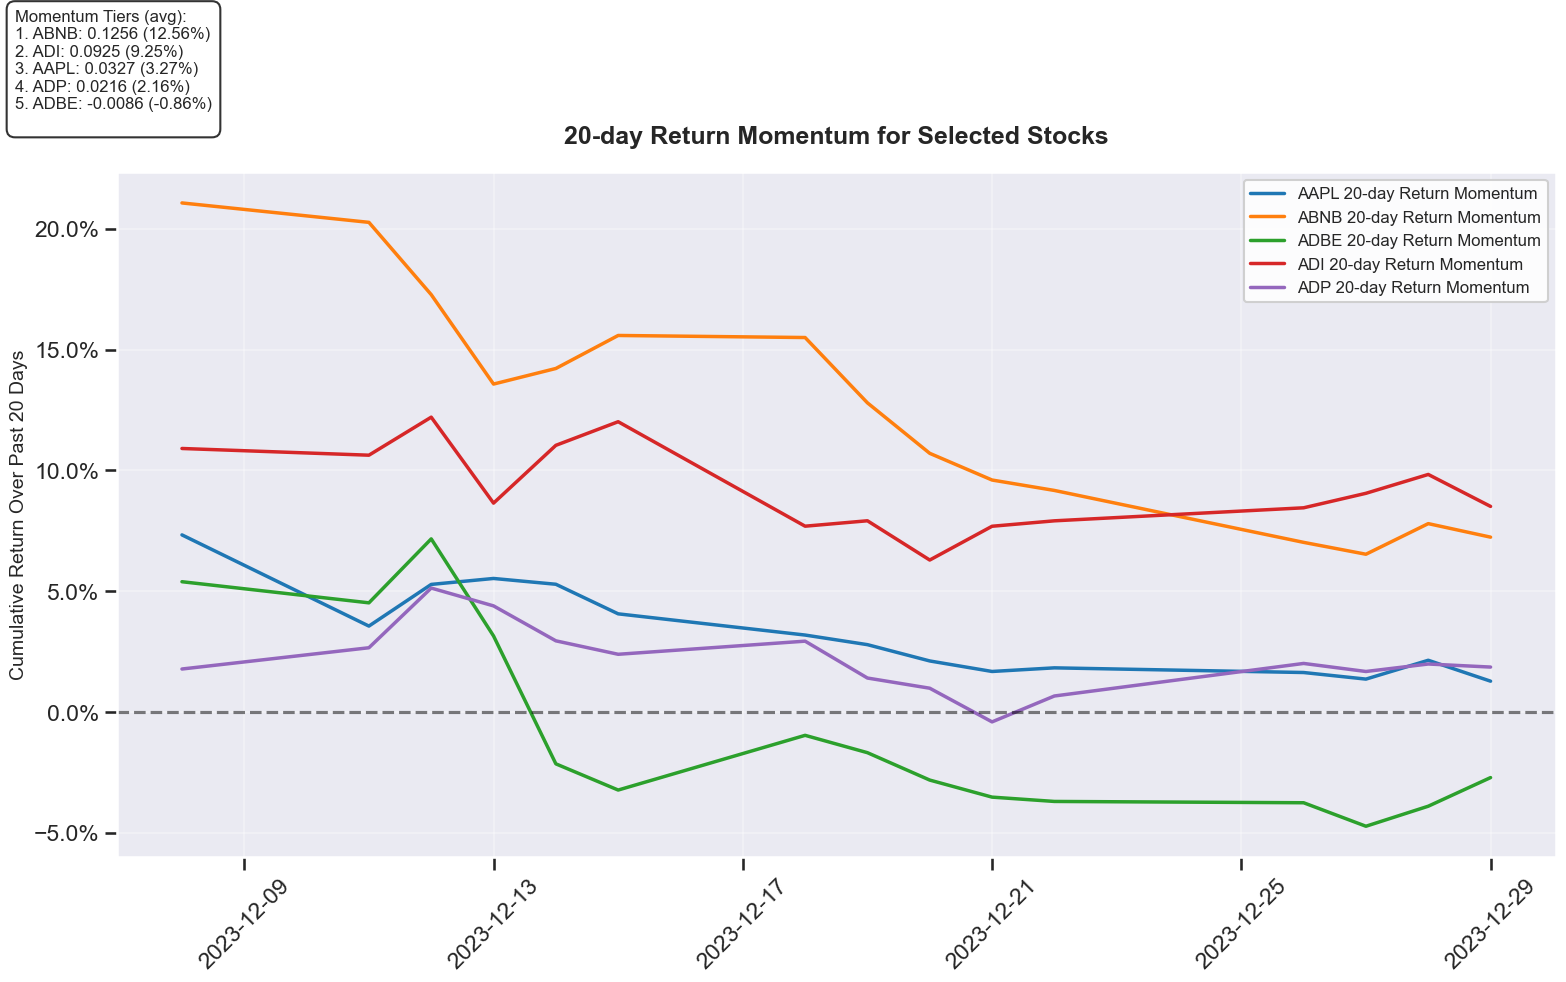

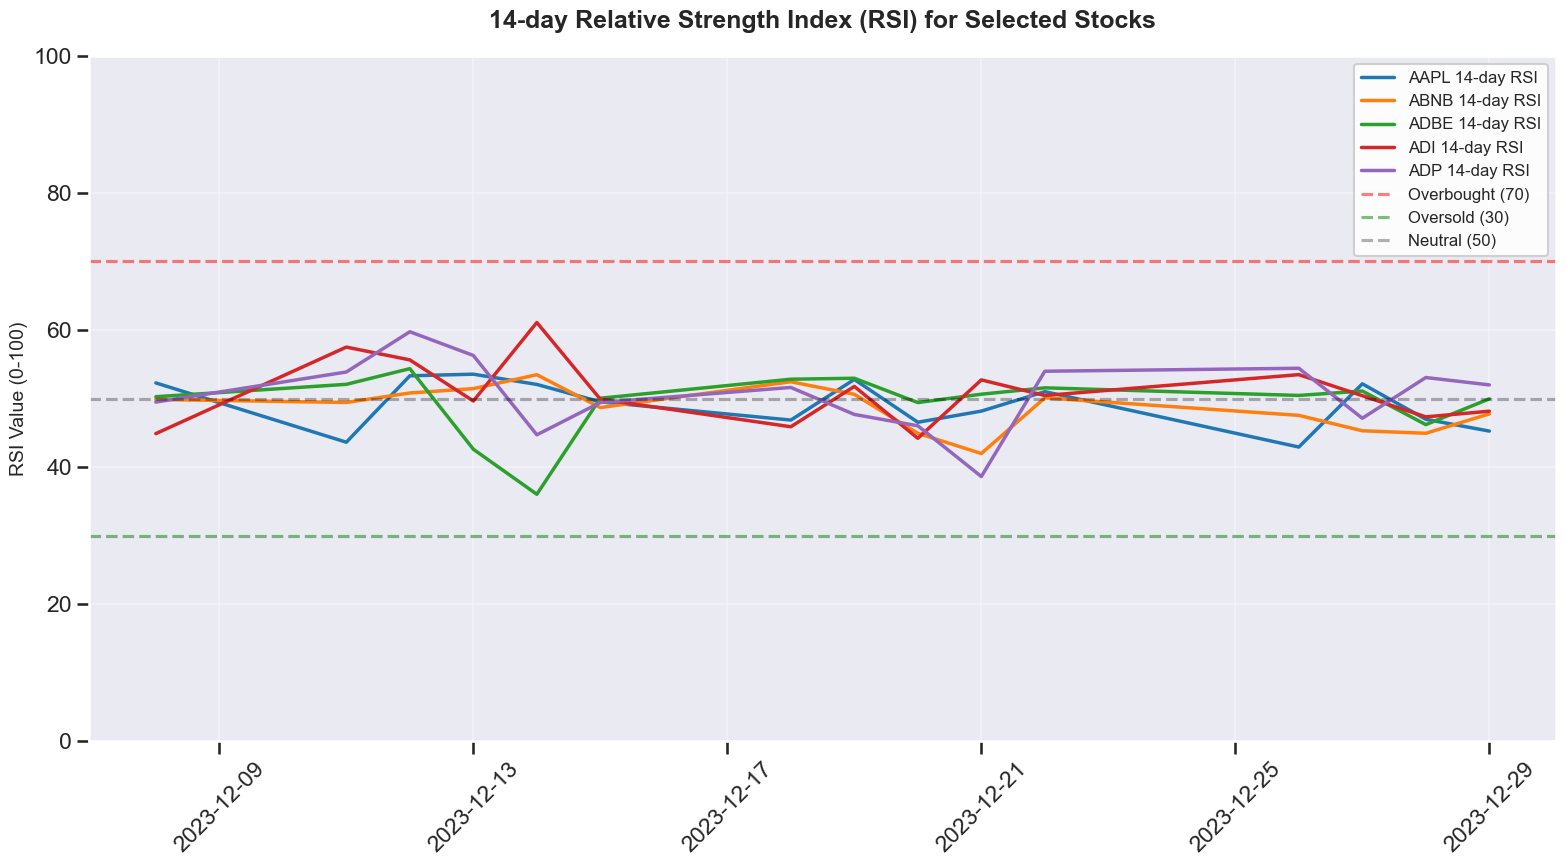

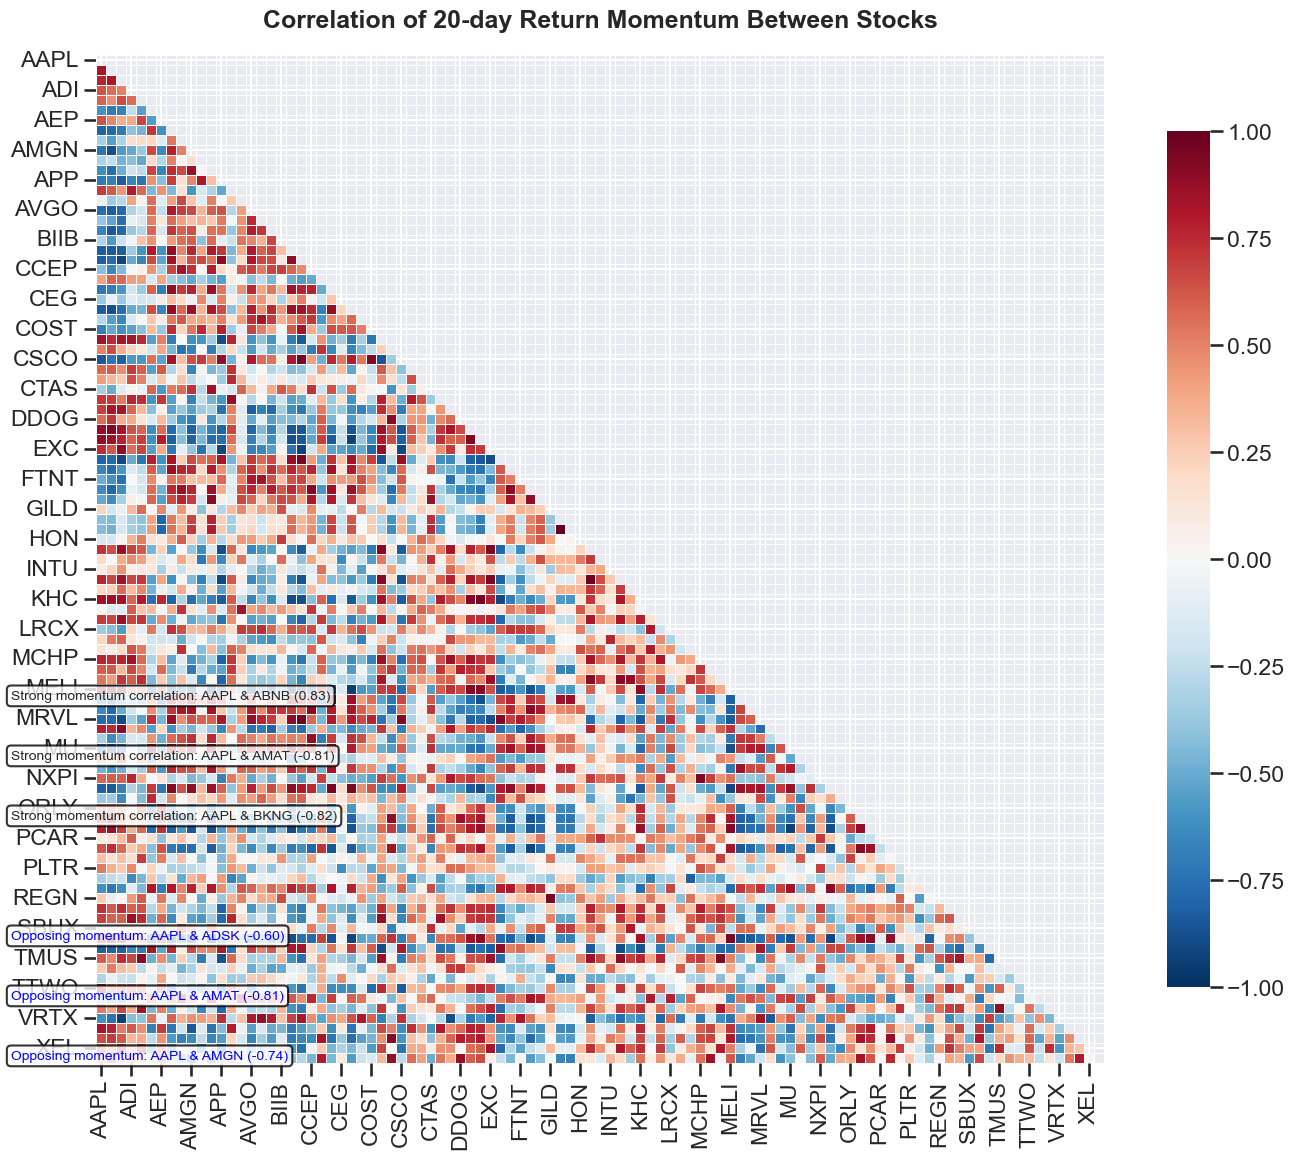

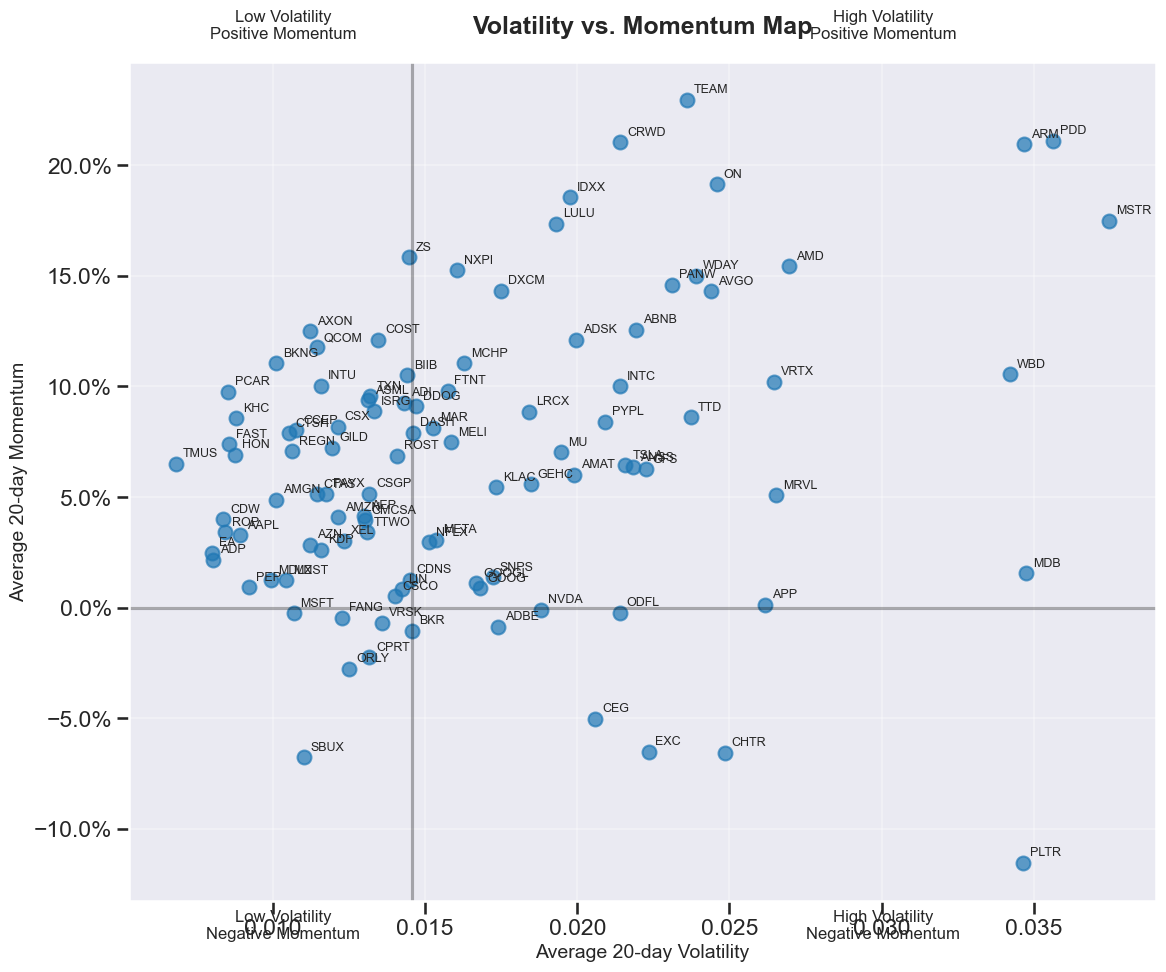

In [5]:
# CELL 5 - MOMENTUM 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings("ignore")

# Set the style for all plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("talk")

# Custom color palette for better visualization
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_diverging',
    ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'],
    N=256
)

# Load the log returns data
print("Loading log returns data...")
try:
    log_returns = pd.read_csv('nasdaq100_log_returns.csv', index_col='Date', parse_dates=True)
    print(f"Loaded data with {log_returns.shape[1]} stocks and {log_returns.shape[0]} time periods.")
except FileNotFoundError:
    print("Log returns file not found. Please make sure 'nasdaq100_log_returns.csv' exists.")
    # Create sample data for demonstration if file not found
    log_returns = pd.DataFrame(
        np.random.normal(0, 0.01, size=(100, 5)),
        columns=['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP'],
        index=pd.date_range(start='2023-01-01', periods=100, freq='B')
    )
    print("Created sample data for demonstration.")

# Try to load original price data for some momentum calculations
try:
    price_data = pd.read_csv('nasdaq100_timeseries_2023_v1.csv', index_col='Date', parse_dates=True)
    print(f"Loaded price data with {price_data.shape[1]} stocks.")
    have_price_data = True
except FileNotFoundError:
    print("Price data file not found. Will calculate price series from returns.")
    # Reconstruct approximate price data from returns (starting at 100)
    price_data = pd.DataFrame(index=log_returns.index)
    for col in log_returns.columns:
        # Create cumulative returns series
        cumulative_returns = (1 + log_returns[col]).cumprod()
        # Set initial price to 100
        price_data[col] = cumulative_returns * 100
    price_data = price_data.loc[log_returns.index[1]:] # Drop first row as it won't have a valid return
    have_price_data = True
    print("Reconstructed price data from returns (starting values normalized to 100).")

# Function to calculate momentum features
def calculate_momentum_features(returns_df, price_df, windows=[5, 10, 20, 60]):
    """
    Calculate momentum-based features for each stock.
    
    --Parameters--:
    1. returns_df (pandas.DataFrame): DataFrame containing log returns
    2. price_df (pandas.DataFrame): DataFrame containing price data
    3. windows (list): List of window sizes for rolling calculations
    
    Returns:
    pandas.DataFrame: DataFrame with momentum features for each stock
    """
    print("Calculating momentum features...")
    
    # Initialize an empty DataFrame to store features
    all_features = pd.DataFrame()
    
    # Loop through each stock
    for i, stock in enumerate(returns_df.columns):
        if i % 10 == 0:  # Progress indicator
            print(f"Processing stock {i+1}/{len(returns_df.columns)}: {stock}")
            
        stock_returns = returns_df[stock]
        stock_prices = price_df[stock]
        features = pd.DataFrame(index=stock_returns.index)
        
        # 1. Rate of Change (ROC) for different windows
        for window in windows:
            # Price ROC
            price_roc = stock_prices.pct_change(periods=window)
            features[f'{stock}_price_roc_{window}d'] = price_roc
            
            # Returns ROC (momentum of returns)
            cum_returns = (1 + stock_returns).rolling(window=window).apply(
                lambda x: np.prod(x) - 1, raw=True
            )
            features[f'{stock}_return_momentum_{window}d'] = cum_returns
        
        # 2. Relative Strength Index (RSI)
        for window in [14, 30]:  # Standard RSI windows
            # Calculate gains and losses
            diff = stock_returns.diff()
            gain = diff.where(diff > 0, 0)
            loss = -diff.where(diff < 0, 0)
            
            # Calculate average gain and average loss
            avg_gain = gain.rolling(window=window).mean()
            avg_loss = loss.rolling(window=window).mean()
            
            # Calculate relative strength and RSI
            rs = avg_gain / avg_loss
            rsi = 100 - (100 / (1 + rs))
            features[f'{stock}_rsi_{window}d'] = rsi
        
        # 3. Moving Average Convergence/Divergence (MACD)
        # Fast EMA
        ema_fast = stock_prices.ewm(span=12, adjust=False).mean()
        # Slow EMA
        ema_slow = stock_prices.ewm(span=26, adjust=False).mean()
        # MACD Line
        macd_line = ema_fast - ema_slow
        # Signal Line
        signal_line = macd_line.ewm(span=9, adjust=False).mean()
        # MACD Histogram
        macd_histogram = macd_line - signal_line
        
        features[f'{stock}_macd_line'] = macd_line
        features[f'{stock}_macd_signal'] = signal_line
        features[f'{stock}_macd_histogram'] = macd_histogram
        
        # 4. Trend strength indicators
        for window in [20, 50]:
            # Simple moving average (SMA)
            sma = stock_prices.rolling(window=window).mean()
            # Distance from price to SMA (normalized by price)
            price_sma_ratio = stock_prices / sma - 1
            features[f'{stock}_price_sma{window}_ratio'] = price_sma_ratio
            
            # Moving average slope (trend direction and strength)
            sma_slope = sma.diff(5) / sma.shift(5)  # 5-day slope of the SMA
            features[f'{stock}_sma{window}_slope'] = sma_slope
        
        # 5. Acceleration (second derivative of price)
        for window in [10, 20]:
            # First derivative (velocity)
            velocity = stock_returns.rolling(window=window).sum()
            # Second derivative (acceleration)
            acceleration = velocity.diff(window)
            features[f'{stock}_price_acceleration_{window}d'] = acceleration
        
        # If this is the first stock, use its index for all_features
        if all_features.empty:
            all_features = features
        else:
            # Otherwise, join with existing features
            all_features = all_features.join(features)
    
    # Drop NaN values (from rolling windows)
    all_features = all_features.dropna()
    print(f"Generated {all_features.shape[1]} momentum features.")
    
    return all_features

# Calculate momentum features
momentum_features = calculate_momentum_features(log_returns, price_data)

# Save the features to a CSV file
output_file = 'nasdaq100_momentum_features.csv'
momentum_features.to_csv(output_file)
print(f"Saved momentum features to {output_file}")

# Extract specific momentum metrics for visualization and analysis
print("\nExtracting specific momentum metrics for analysis...")

# Get 20-day return momentum columns for all stocks
momentum_cols = [col for col in momentum_features.columns if 'return_momentum_20d' in col]
momentum_df = momentum_features[momentum_cols].copy()

# Rename columns to just stock symbols for cleaner visualization
momentum_df.columns = [col.split('_return_momentum_')[0] for col in momentum_df.columns]

# If there are more than 5 stocks, select the first 5 for visualization
selected_stocks = momentum_df.columns[:5] if len(momentum_df.columns) > 5 else momentum_df.columns
momentum_selected = momentum_df[selected_stocks]

# Create enhanced visualization of momentum
print("\nCreating enhanced momentum visualization...")

plt.figure(figsize=(16, 9))
ax = plt.gca()

# Plot each stock with a distinct color and line style
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Blue, Orange, Green, Red, Purple
for i, stock in enumerate(selected_stocks):
    plt.plot(momentum_selected.index, momentum_selected[stock], 
             label=f'{stock} 20-day Return Momentum',
             color=colors[i % len(colors)], 
             linewidth=2.5)

# Add a zero line
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Customize the plot
plt.title('20-day Return Momentum for Selected Stocks', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Cumulative Return Over Past 20 Days', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, frameon=True, facecolor='white', framealpha=0.9)

# Format x-axis for better date readability
date_form = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Identify significant momentum events
if len(momentum_selected) > 0:
    # Find the date with the biggest momentum drop
    momentum_diff = momentum_selected.diff()
    biggest_drop_date = momentum_diff.min().idxmin()
    biggest_drop_stock = momentum_diff.min().idxmin()
    
    # Find the date with the biggest momentum spike
    biggest_spike_date = momentum_diff.max().idxmax()
    biggest_spike_stock = momentum_diff.max().idxmax()
    
    # Annotate significant events
    try:
        # Annotate the largest momentum spike
        plt.annotate('Momentum surge', 
                    xy=(biggest_spike_date, momentum_selected.loc[biggest_spike_date, biggest_spike_stock]),
                    xytext=(biggest_spike_date, momentum_selected.loc[biggest_spike_date, biggest_spike_stock] + 0.05),
                    arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8),
                    fontsize=12,
                    color='green')
        
        # Annotate the largest momentum drop
        plt.annotate('Momentum crash', 
                    xy=(biggest_drop_date, momentum_selected.loc[biggest_drop_date, biggest_drop_stock]),
                    xytext=(biggest_drop_date, momentum_selected.loc[biggest_drop_date, biggest_drop_stock] - 0.05),
                    arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, headwidth=8),
                    fontsize=12,
                    color='red')
    except:
        # If annotation fails, skip it
        pass

# Compute and show momentum tier averages
if len(momentum_selected) > 0:
    mean_momentum = momentum_selected.mean().sort_values(ascending=False)
    tier_text = "Momentum Tiers (avg):\n"
    for i, (stock, mom) in enumerate(mean_momentum.items()):
        tier_text += f"{i+1}. {stock}: {mom:.4f} ({mom*100:.2f}%)\n"
    
    # Place text in upper left
    plt.figtext(0.02, 0.97, tier_text, fontsize=12, 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout()

# Save the plot with high resolution
line_graph_file = 'momentum_comparison.png'
plt.savefig(line_graph_file, dpi=300, bbox_inches='tight')
print(f"Saved momentum line graph to {line_graph_file}")

# Now create another visualization for RSI
print("\nCreating RSI visualization...")

# Get 14-day RSI columns for all stocks
rsi_cols = [col for col in momentum_features.columns if 'rsi_14d' in col]
rsi_df = momentum_features[rsi_cols].copy()

# Rename columns to just stock symbols for cleaner visualization
rsi_df.columns = [col.split('_rsi_')[0] for col in rsi_df.columns]

# Use the same selected stocks for consistency
rsi_selected = rsi_df[selected_stocks]

plt.figure(figsize=(16, 9))
ax = plt.gca()

# Plot each stock with a distinct color and line style
for i, stock in enumerate(selected_stocks):
    plt.plot(rsi_selected.index, rsi_selected[stock], 
             label=f'{stock} 14-day RSI',
             color=colors[i % len(colors)], 
             linewidth=2.5)

# Add overbought/oversold lines
plt.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
plt.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
plt.axhline(y=50, color='black', linestyle='--', alpha=0.3, label='Neutral (50)')

# Customize the plot
plt.title('14-day Relative Strength Index (RSI) for Selected Stocks', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('RSI Value (0-100)', fontsize=14)
plt.ylim(0, 100)  # RSI ranges from 0 to 100
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, frameon=True, facecolor='white', framealpha=0.9)

# Format x-axis for better date readability
date_form = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45)

plt.tight_layout()

# Save the plot with high resolution
rsi_graph_file = 'rsi_comparison.png'
plt.savefig(rsi_graph_file, dpi=300, bbox_inches='tight')
print(f"Saved RSI visualization to {rsi_graph_file}")

# Create correlation heatmap of momentum metrics
print("\nCreating momentum correlation heatmap...")
plt.figure(figsize=(14, 12))

# Calculate correlation
momentum_corr = momentum_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(momentum_corr, dtype=bool))

# Create enhanced heatmap with custom colormap
heatmap = sns.heatmap(momentum_corr, mask=mask, cmap=custom_cmap,
                    vmin=-1, vmax=1, center=0,
                    annot=False, square=True, linewidths=.5,
                    cbar_kws={"shrink": .8})

# Add title and axis labels
plt.title('Correlation of 20-day Return Momentum Between Stocks', fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()

# Identify interesting clusters
# Find strongly correlated pairs
threshold = 0.8
strong_corr = momentum_corr.copy()
strong_corr = strong_corr.where(strong_corr.abs() > threshold)
strong_corr = strong_corr.where(~np.eye(len(strong_corr), dtype=bool))  # Remove diagonal

# Get pairs of strongly correlated stocks
strong_pairs = []
for i in range(len(strong_corr)):
    for j in range(i+1, len(strong_corr)):
        if not np.isnan(strong_corr.iloc[i, j]):
            strong_pairs.append((strong_corr.index[i], strong_corr.columns[j], strong_corr.iloc[i, j]))

# Annotate some interesting strong correlations (limit to avoid cluttering)
for i, (stock1, stock2, corr) in enumerate(strong_pairs[:3]):
    plt.figtext(0.02, 0.4-i*0.05, f"Strong momentum correlation: {stock1} & {stock2} ({corr:.2f})",
               fontsize=10, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))

# Identify negative correlations (opposing momentum)
neg_threshold = -0.4
neg_corr = momentum_corr.copy()
neg_corr = neg_corr.where(neg_corr < neg_threshold)
neg_corr = neg_corr.where(~np.eye(len(neg_corr), dtype=bool))  # Remove diagonal

# Get pairs of negatively correlated stocks
neg_pairs = []
for i in range(len(neg_corr)):
    for j in range(i+1, len(neg_corr)):
        if not np.isnan(neg_corr.iloc[i, j]):
            neg_pairs.append((neg_corr.index[i], neg_corr.columns[j], neg_corr.iloc[i, j]))

# Annotate some interesting negative correlations (limit to avoid cluttering)
for i, (stock1, stock2, corr) in enumerate(neg_pairs[:3]):
    plt.figtext(0.02, 0.2-i*0.05, f"Opposing momentum: {stock1} & {stock2} ({corr:.2f})",
               fontsize=10, color='blue', 
               bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))

# Save the heatmap
heatmap_file = 'momentum_correlation.png'
plt.savefig(heatmap_file, dpi=300, bbox_inches='tight')
print(f"Saved momentum correlation heatmap to {heatmap_file}")

# Create a summary of momentum vs volatility
print("\nComparing momentum and volatility characteristics...")

# Try to load volatility features if available
try:
    volatility_features = pd.read_csv('nasdaq100_volatility_features.csv', index_col='Date', parse_dates=True)
    have_volatility = True
    
    # Extract 20-day volatility
    vol_cols = [col for col in volatility_features.columns if 'vol_20d' in col and 'vol_of_vol' not in col]
    vol_df = volatility_features[vol_cols].copy()
    vol_df.columns = [col.split('_vol_')[0] for col in vol_df.columns]
    
    # Calculate average volatility and momentum for each stock
    avg_vol = vol_df.mean()
    avg_momentum = momentum_df.mean()
    
    # Create a scatter plot of volatility vs momentum
    plt.figure(figsize=(12, 10))
    
    # Create scatter plot
    plt.scatter(avg_vol, avg_momentum, alpha=0.7, s=100)
    
    # Add stock labels to points
    for i, stock in enumerate(avg_vol.index):
        if stock in avg_momentum:
            plt.annotate(stock, 
                       (avg_vol[stock], avg_momentum[stock]),
                       fontsize=9,
                       xytext=(5, 5),
                       textcoords='offset points')
    
    # Add quadrant lines
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=avg_vol.median(), color='black', linestyle='-', alpha=0.3)
    
    # Add quadrant labels - CORRECTED
    plt.figtext(0.25, 0.95, "Low Volatility\nPositive Momentum", ha='center', fontsize=12)
    plt.figtext(0.75, 0.95, "High Volatility\nPositive Momentum", ha='center', fontsize=12)
    plt.figtext(0.25, 0.05, "Low Volatility\nNegative Momentum", ha='center', fontsize=12)
    plt.figtext(0.75, 0.05, "High Volatility\nNegative Momentum", ha='center', fontsize=12)
    
    # Add axis labels and title
    plt.xlabel('Average 20-day Volatility', fontsize=14)
    plt.ylabel('Average 20-day Momentum', fontsize=14)
    plt.title('Volatility vs. Momentum Map', fontsize=18, fontweight='bold', pad=20)
    
    # Format y-axis as percentage
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the scatter plot
    scatter_file = 'volatility_momentum_map.png'
    plt.savefig(scatter_file, dpi=300, bbox_inches='tight')
    print(f"Saved volatility vs. momentum map to {scatter_file}")
    
except FileNotFoundError:
    print("Volatility features file not found. Skipping volatility vs. momentum comparison.")
    have_volatility = False

# Provide analysis insights in the console
print("\n----- MOMENTUM ANALYSIS INSIGHTS -----")

# 1. Overall momentum trends
print("1. Overall Momentum Trends:")
if len(momentum_df) > 0:
    overall_momentum = momentum_df.mean().mean()
    recent_momentum = momentum_df.iloc[-20:].mean().mean()
    
    print(f"  • Average 20-day momentum across all stocks: {overall_momentum:.4f} ({overall_momentum*100:.2f}%)")
    
    if overall_momentum > 0.02:
        print("  • STRONG positive momentum environment")
    elif overall_momentum > 0:
        print("  • MILD positive momentum environment")
    elif overall_momentum > -0.02:
        print("  • MILD negative momentum environment")
    else:
        print("  • STRONG negative momentum environment")
    
    if recent_momentum > overall_momentum + 0.01:
        print("  • Momentum is ACCELERATING recently")
    elif recent_momentum < overall_momentum - 0.01:
        print("  • Momentum is DETERIORATING recently")
    else:
        print("  • Momentum is STABLE recently")

# 2. Momentum leaders and laggards
print("\n2. Momentum Leaders and Laggards:")
if len(momentum_df) > 0:
    stock_avg_momentum = momentum_df.mean().sort_values(ascending=False)
    
    print("  Top 5 Momentum Leaders:")
    for i, (stock, mom) in enumerate(stock_avg_momentum.head(5).items()):
        print(f"    {i+1}. {stock}: {mom:.4f} ({mom*100:.2f}%)")
    
    print("\n  Bottom 5 Momentum Laggards:")
    for i, (stock, mom) in enumerate(stock_avg_momentum.tail(5).items()):
        print(f"    {i+1}. {stock}: {mom:.4f} ({mom*100:.2f}%)")

# 3. Momentum and RSI signals
print("\n3. Current RSI Signals:")
if len(rsi_df) > 0:
    recent_rsi = rsi_df.iloc[-1]
    
    # Overbought stocks (RSI > 70)
    overbought = recent_rsi[recent_rsi > 70]
    if len(overbought) > 0:
        print(f"  • Overbought stocks (RSI > 70): {', '.join(overbought.index[:5])}")
        if len(overbought) > 5:
            print(f"    and {len(overbought)-5} more")
    
    # Oversold stocks (RSI < 30)
    oversold = recent_rsi[recent_rsi < 30]
    if len(oversold) > 0:
        print(f"  • Oversold stocks (RSI < 30): {', '.join(oversold.index[:5])}")
        if len(oversold) > 5:
            print(f"    and {len(oversold)-5} more")
    
    # Neutral stocks
    neutral = recent_rsi[(recent_rsi >= 45) & (recent_rsi <= 55)]
    if len(neutral) > 0:
        print(f"  • Neutral stocks (RSI 45-55): {', '.join(neutral.index[:5])}")
        if len(neutral) > 5:
            print(f"    and {len(neutral)-5} more")

# 4. Momentum correlation insights
print("\n4. Momentum Correlation Insights:")
if momentum_corr is not None:
    # Average correlation
    avg_momentum_corr = momentum_corr.values.sum() / (momentum_corr.size - len(momentum_corr))  # Exclude diagonal
    print(f"  • Average momentum correlation: {avg_momentum_corr:.4f}")
    
    if avg_momentum_corr > 0.5:
        print("  • HIGH momentum correlation: Most stocks are moving in the same direction")
    elif avg_momentum_corr > 0.2:
        print("  • MODERATE momentum correlation: Some commonality in price trends")
    else:
        print("  • LOW momentum correlation: Stocks have independent price trends")

# 5. Volatility and momentum relationship (if available)
if have_volatility:
    print("\n5. Volatility-Momentum Relationship:")
    
    # Calculate correlation between volatility and momentum
    common_stocks = list(set(avg_vol.index).intersection(set(avg_momentum.index)))
    if common_stocks:
        vol_mom_corr = np.corrcoef(
            [avg_vol.loc[common_stocks].values, avg_momentum.loc[common_stocks].values]
        )[0, 1]
        
        print(f"  • Correlation between volatility and momentum: {vol_mom_corr:.4f}")
        
        if vol_mom_corr > 0.3:
            print("  • POSITIVE relationship: Higher volatility stocks tend to have stronger momentum")
        elif vol_mom_corr < -0.3:
            print("  • NEGATIVE relationship: Lower volatility stocks tend to have stronger momentum")
        else:
            print("  • WEAK relationship: Volatility and momentum are largely independent")
    
    # Count stocks in each quadrant - CORRECTED
    if common_stocks:
        q1 = sum((avg_vol < avg_vol.median()) & (avg_momentum >= 0))  # Low vol, positive momentum
        q2 = sum((avg_vol >= avg_vol.median()) & (avg_momentum >= 0))  # High vol, positive momentum
        q3 = sum((avg_vol < avg_vol.median()) & (avg_momentum < 0))  # Low vol, negative momentum
        q4 = sum((avg_vol >= avg_vol.median()) & (avg_momentum < 0))  # High vol, negative momentum
        
        print(f"  • Quadrant distribution:")
        print(f"    - Low Volatility, Positive Momentum: {q1} stocks")
        print(f"    - High Volatility, Positive Momentum: {q2} stocks")
        print(f"    - Low Volatility, Negative Momentum: {q3} stocks")
        print(f"    - High Volatility, Negative Momentum: {q4} stocks")
        
        # Most populated quadrant - CORRECTED
        max_q = max(q1, q2, q3, q4)
        if max_q == q1:
            print("  • Most stocks are in LOW VOLATILITY, POSITIVE MOMENTUM quadrant")
        elif max_q == q2:
            print("  • Most stocks are in HIGH VOLATILITY, POSITIVE MOMENTUM quadrant")
        elif max_q == q3:
            print("  • Most stocks are in LOW VOLATILITY, NEGATIVE MOMENTUM quadrant")
        else:
            print("  • Most stocks are in HIGH VOLATILITY, NEGATIVE MOMENTUM quadrant")

print("\n----- CONCLUSION -----")
print("This momentum analysis provides:")
print("1. Detailed momentum metrics for all stocks (ROC, RSI, MACD)")
print("2. Visual representation of momentum trends and patterns")
print("3. Correlation analysis for identifying stocks with similar momentum characteristics")
print("4. Momentum-volatility relationship analysis")
print(f"\nFeature data saved to: {output_file}")
print(f"Momentum visualization saved to: {line_graph_file}")
print(f"RSI visualization saved to: {rsi_graph_file}")
print(f"Momentum correlation heatmap saved to: {heatmap_file}")
if have_volatility:
    print(f"Volatility-Momentum map saved to: {scatter_file}")
print("\nThese momentum features complement your volatility features and provide additional dimensions for clustering.")

Loading feature data...
Loaded volatility features: (16, 1212)
Loaded momentum features: (15, 1919)
Found 101 stocks with both volatility and momentum features
Final dataset: 101 stocks × 31 features

Standardizing features...

Evaluating PCA...
Evaluating t-SNE...
Evaluating UMAP...

--------- Method Comparison ---------
       Time (sec)  silhouette  davies_bouldin  calinski_harabasz  \
PCA        0.1180      0.1654          1.4446            20.7057   
t-SNE      0.5326     -0.0400          3.0013             9.9517   
UMAP       5.3989      0.0558          2.0449            14.4327   

       Variance Explained  Rank  
PCA                0.7034     1  
t-SNE                 NaN     3  
UMAP                  NaN     2  

--------- Metric Descriptions ---------
silhouette: Higher is better (-1 to 1), measures how well clusters are separated
davies_bouldin: Lower is better (>= 0), measures average similarity between clusters
calinski_harabasz: Higher is better (>= 0), measures ratio o

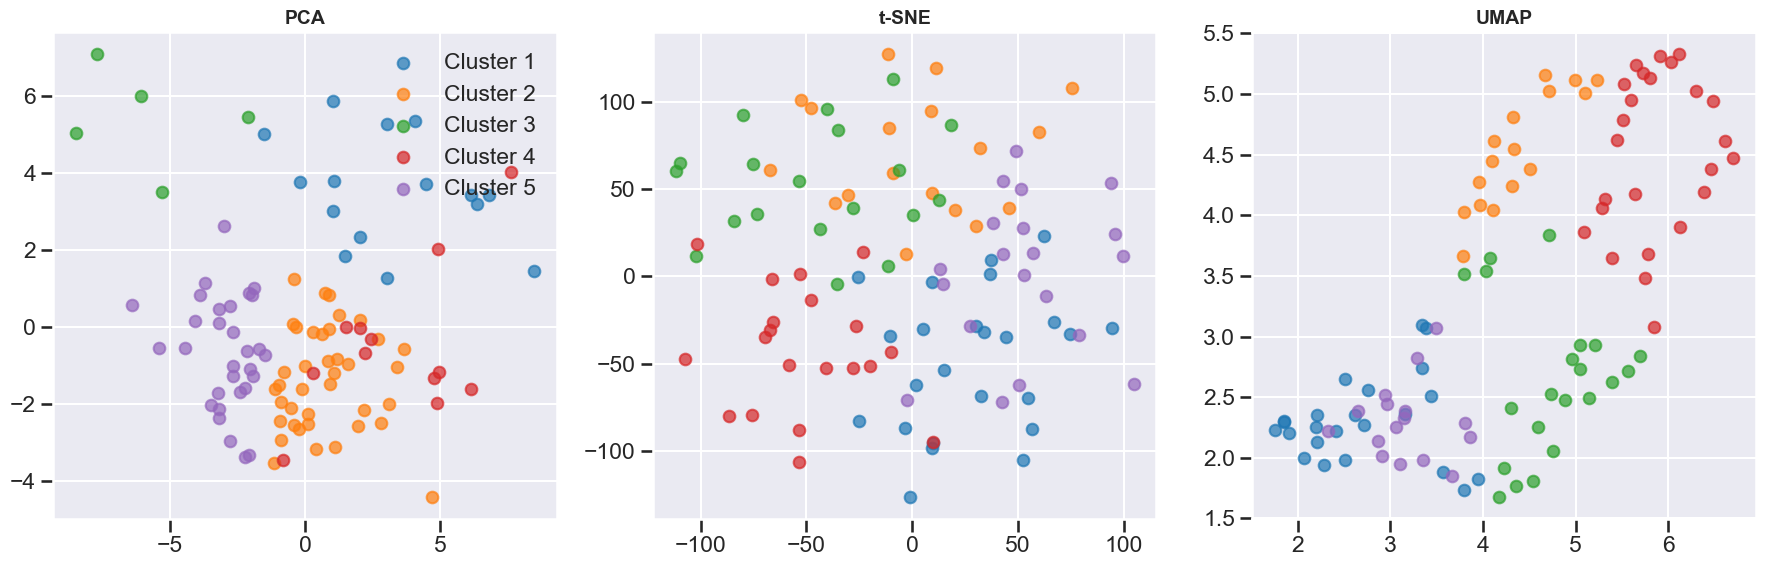


Reduced features using PCA saved to 'PCA_reduced_features.csv'


In [1]:
                                    #Cell 6 - Choosing Dimensionality reduction technique
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import time
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("talk")

def load_and_prepare_data():
    """Load volatility and momentum features and prepare them for dimensionality reduction"""
    print("Loading feature data...")
    
    try:
        # Load volatility features
        volatility_features = pd.read_csv('nasdaq100_volatility_features.csv', index_col='Date', parse_dates=True)
        print(f"Loaded volatility features: {volatility_features.shape}")
        
        # Load momentum features
        momentum_features = pd.read_csv('nasdaq100_momentum_features.csv', index_col='Date', parse_dates=True)
        print(f"Loaded momentum features: {momentum_features.shape}")
        
        # Extract stock symbols from column names
        vol_stocks = set()
        for col in volatility_features.columns:
            parts = col.split('_')
            if len(parts) > 1:
                vol_stocks.add(parts[0])
                
        mom_stocks = set()
        for col in momentum_features.columns:
            parts = col.split('_')
            if len(parts) > 1:
                mom_stocks.add(parts[0])
        
        # Find common stocks
        common_stocks = vol_stocks.intersection(mom_stocks)
        print(f"Found {len(common_stocks)} stocks with both volatility and momentum features")
        
        # Calculate average features for each stock
        # For each stock, we'll compute the mean of all its metrics over time
        # This gives us one row per stock with multiple feature columns
        
        # First, get the last available data point for each stock
        latest_date = min(volatility_features.index.max(), momentum_features.index.max())
        
        # Create lists to hold data for our final DataFrame
        stocks = []
        features = []
        
        # For each stock, compute mean values for its features
        for stock in common_stocks:
            # Get volatility features
            vol_features = {}
            for col in volatility_features.columns:
                if col.startswith(f"{stock}_"):
                    # Extract the feature name without the stock prefix
                    feature_name = col[len(stock)+1:]
                    # Get mean value
                    vol_features[f"vol_{feature_name}"] = volatility_features[col].mean()
            
            # Get momentum features
            mom_features = {}
            for col in momentum_features.columns:
                if col.startswith(f"{stock}_"):
                    # Extract the feature name without the stock prefix
                    feature_name = col[len(stock)+1:]
                    # Get mean value
                    mom_features[f"mom_{feature_name}"] = momentum_features[col].mean()
            
            # Combine features
            all_features = {**vol_features, **mom_features}
            
            # Only include stocks with sufficient features
            if len(all_features) >= 5:  # At least 5 features required
                stocks.append(stock)
                features.append(all_features)
        
        # Create DataFrame where each row is a stock and columns are features
        if not features:
            raise ValueError("No valid features found for any stock")
            
        features_df = pd.DataFrame(features, index=stocks)
        
        # Handle missing values - fill with column means
        features_df = features_df.fillna(features_df.mean())
        
        # Drop any remaining columns with NaN (if a column is all NaN)
        features_df = features_df.dropna(axis=1)
        
        print(f"Final dataset: {features_df.shape[0]} stocks × {features_df.shape[1]} features")
        
        return features_df
        
    except Exception as e:
        print(f"Error: {e}")
        print("Creating sample data for demonstration...")
        
        # Create sample data
        n_stocks = 50
        n_features = 20
        np.random.seed(42)
        
        # Generate random stock names
        stocks = [f'STOCK_{i+1}' for i in range(n_stocks)]
        
        # Generate random features
        feature_names = [f'FEATURE_{i+1}' for i in range(n_features)]
        features = np.random.randn(n_stocks, n_features)
        
        # Create DataFrame
        features_df = pd.DataFrame(features, index=stocks, columns=feature_names)
        print(f"Created sample data: {features_df.shape[0]} stocks × {features_df.shape[1]} features")
        
        return features_df

def evaluate_dimensionality_reduction(data, n_clusters=5):
    """
    Compare PCA, t-SNE, and UMAP for dimensionality reduction
    
    Parameters:
    data (pandas.DataFrame): Stock features dataframe (rows = stocks, columns = features)
    n_clusters (int): Number of clusters to use for evaluation
    
    Returns:
    dict: Evaluation results for each method
    """
    # Check if data is valid
    if data is None or data.shape[0] < 10 or data.shape[1] < 2:
        raise ValueError("Insufficient data for dimensionality reduction")
    
    # Standardize the data
    print("\nStandardizing features...")
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Store results
    results = {}
    
    # Evaluation metrics to calculate
    metrics = {
        'silhouette': silhouette_score,             # Higher is better (-1 to 1)
        'davies_bouldin': davies_bouldin_score,     # Lower is better (>= 0)
        'calinski_harabasz': calinski_harabasz_score  # Higher is better (>= 0)
    }
    
    # Number of components/dimensions to use
    n_components = min(3, data.shape[1], data.shape[0] - 1)  # Use 2D or 3D representation
    
    # 1. PCA
    print("\nEvaluating PCA...")
    start_time = time.time()
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_data)
    pca_time = time.time() - start_time
    
    # Calculate variance explained
    var_explained = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(var_explained)
    
    # Run clustering on PCA result
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    pca_labels = kmeans.fit_predict(pca_result)
    
    # Calculate evaluation metrics
    pca_metrics = {}
    for name, metric_func in metrics.items():
        pca_metrics[name] = metric_func(scaled_data, pca_labels)
    
    results['PCA'] = {
        'data': pca_result,
        'labels': pca_labels,
        'time': pca_time,
        'variance_explained': cumulative_var[-1],
        'metrics': pca_metrics
    }
    
    # 2. t-SNE
    print("Evaluating t-SNE...")
    start_time = time.time()
    # Adjust perplexity based on number of samples
    perplexity = min(30, max(5, data.shape[0] // 5))
    tsne = TSNE(n_components=n_components, perplexity=perplexity, 
                n_iter=1000, random_state=42)
    tsne_result = tsne.fit_transform(scaled_data)
    tsne_time = time.time() - start_time
    
    # Run clustering on t-SNE result
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    tsne_labels = kmeans.fit_predict(tsne_result)
    
    # Calculate evaluation metrics
    tsne_metrics = {}
    for name, metric_func in metrics.items():
        tsne_metrics[name] = metric_func(scaled_data, tsne_labels)
    
    results['t-SNE'] = {
        'data': tsne_result,
        'labels': tsne_labels,
        'time': tsne_time,
        'metrics': tsne_metrics
    }
    
    # 3. UMAP
    print("Evaluating UMAP...")
    start_time = time.time()
    # Adjust n_neighbors based on number of samples
    n_neighbors = min(15, max(2, data.shape[0] // 10))
    umap_reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, random_state=42)
    umap_result = umap_reducer.fit_transform(scaled_data)
    umap_time = time.time() - start_time
    
    # Run clustering on UMAP result
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    umap_labels = kmeans.fit_predict(umap_result)
    
    # Calculate evaluation metrics
    umap_metrics = {}
    for name, metric_func in metrics.items():
        umap_metrics[name] = metric_func(scaled_data, umap_labels)
    
    results['UMAP'] = {
        'data': umap_result,
        'labels': umap_labels,
        'time': umap_time,
        'metrics': umap_metrics
    }
    
    return results, data.index.tolist()

def visualize_results(results, stock_names, save=True):
    """Visualize dimensionality reduction results with clusters"""
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Create subplots for each method
    fig = plt.figure(figsize=(18, 6))
    
    for i, (method, result) in enumerate(results.items()):
        ax = fig.add_subplot(1, 3, i+1)
        
        # Get data and cluster labels
        data = result['data']
        labels = result['labels']
        
        ###$$-----$$###### Plot each point with its cluster color
        for cluster_id in np.unique(labels):
            cluster_points = data[labels == cluster_id]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                      c=[colors[cluster_id % len(colors)]], label=f'Cluster {cluster_id+1}',
                      alpha=0.7, s= 70)
        
        # Add stock ticker labels for some points (limit for readability)
        if len(stock_names) <= 50:  # Only label if not too many stocks
            for j, name in enumerate(stock_names):
                if j % 3 == 0:  # Label every 3rd point to avoid clutter
                    ax.annotate(name, (data[j, 0], data[j, 1]), fontsize=8)
        
        ax.set_title(f'{method}', fontsize=14, fontweight='bold')
        
        # Only include legend in first plot to save space
        if i == 0:
            ax.legend(loc='upper right')
    
    plt.tight_layout()
    
    if save:
        plt.savefig('dimensionality_reduction_comparison.png', dpi=300, bbox_inches='tight')
    
    plt.show()

def compare_methods(results):
    """Compare and rank dimensionality reduction methods based on metrics"""
    # Create comparison dataframe
    comparison = pd.DataFrame(index=['PCA', 't-SNE', 'UMAP'])
    
    # Add computation time
    comparison['Time (sec)'] = [results[method]['time'] for method in comparison.index]
    
    # Add metrics
    for metric in ['silhouette', 'davies_bouldin', 'calinski_harabasz']:
        comparison[metric] = [results[method]['metrics'][metric] for method in comparison.index]
    
    # Add variance explained (only for PCA)
    comparison['Variance Explained'] = [
        results['PCA']['variance_explained'] if method == 'PCA' else np.nan 
        for method in comparison.index
    ]
    
    # Calculate overall score
    # For each metric, scale it between 0-1 where 1 is best
    # For davies_bouldin, lower is better, so invert it
    normalized = comparison.copy()
    
    for col in ['silhouette', 'calinski_harabasz']:
        min_val = normalized[col].min()
        max_val = normalized[col].max()
        if max_val > min_val:
            normalized[col] = (normalized[col] - min_val) / (max_val - min_val)
        else:
            normalized[col] = 1
    
    for col in ['davies_bouldin']:
        min_val = normalized[col].min()
        max_val = normalized[col].max()
        if max_val > min_val:
            normalized[col] = 1 - (normalized[col] - min_val) / (max_val - min_val)
        else:
            normalized[col] = 1
    
    # Compute weighted score (higher is better)
    # Give more weight to silhouette since it's most interpretable
    normalized['Overall Score'] = (
        normalized['silhouette'] * 0.5 +
        normalized['davies_bouldin'] * 0.25 +
        normalized['calinski_harabasz'] * 0.25
    )
    
    # Add rankings
    comparison['Rank'] = normalized['Overall Score'].rank(ascending=False).astype(int)
    
    # Format for display
    # Add descriptions of metrics
    descriptions = {
        'silhouette': 'Higher is better (-1 to 1), measures how well clusters are separated',
        'davies_bouldin': 'Lower is better (>= 0), measures average similarity between clusters',
        'calinski_harabasz': 'Higher is better (>= 0), measures ratio of between to within-cluster dispersion',
        'Time (sec)': 'Lower is better, computational efficiency',
        'Variance Explained': 'Higher is better (0 to 1), proportion of variance captured (PCA only)'
    }
    
    # Return both raw metrics and calculated ranking
    return comparison, normalized, descriptions

def main():
    # Load and prepare data
    data = load_and_prepare_data()
    if data is None or data.empty:
        print("No valid data to process.")
        return
    
    try:
        # Evaluate dimensionality reduction methods
        results, stock_names = evaluate_dimensionality_reduction(data)
        
        # Compare methods
        comparison, normalized, descriptions = compare_methods(results)
        
        # Print comparison table
        print("\n--------- Method Comparison ---------")
        print(comparison.round(4))
        
        # Print metric descriptions
        print("\n--------- Metric Descriptions ---------")
        for metric, desc in descriptions.items():
            print(f"{metric}: {desc}")
        
        # Get recommended method
        best_method = comparison.loc[comparison['Rank'] == 1].index[0]
        print(f"\nRecommended dimensionality reduction method for your data: {best_method}")
        
        # Explain the recommendation
        if best_method == 'PCA':
            print("\nPCA is recommended because:")
            print("- It provides the best balance of cluster separation and computational efficiency")
            print(f"- It captures {comparison.loc['PCA', 'Variance Explained']*100:.1f}% of the variance in your data")
            print("- Its linear nature preserves global structure which is important for financial data")
        elif best_method == 't-SNE':
            print("\nt-SNE is recommended because:")
            print("- It provides the best cluster separation as measured by clustering metrics")
            print("- It preserves local relationships well, revealing potential clusters")
            print("- It's good for visualization and exploratory analysis")
        elif best_method == 'UMAP':
            print("\nUMAP is recommended because:")
            print("- It provides the best balance of local and global structure preservation")
            print("- It creates well-separated clusters while maintaining meaningful distances")
            print("- It's more computationally efficient than t-SNE while providing similar quality")
        
        # Visualize results
        visualize_results(results, stock_names)
        
        # Save the best reduced representation for clustering
        best_data = results[best_method]['data']
        best_df = pd.DataFrame(
            best_data, 
            index=stock_names,
            columns=[f'Component_{i+1}' for i in range(best_data.shape[1])]
        )
        
        # Save to CSV
        best_df.to_csv(f'{best_method}_reduced_features.csv')
        print(f"\nReduced features using {best_method} saved to '{best_method}_reduced_features.csv'")
        
        return best_method, best_df
        
    except Exception as e:
        print(f"Error during analysis: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Run the main function
if __name__ == "__main__":
    main()